# Car residual value modelling (PoC)

## I. Importer les librairies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import joblib
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.models import DataPreprocessor, univariate_analysis, bivariate_analysis, multivariate_analysis, scatter_3d
from src.models import create_transformer_pipeline
from src.models import CategoricalEmbedding, plot_embeddings, visualize_all_embeddings, get_embedding_weights, cluster_embeddings
from src.models import model_evaluation
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import tensorflow as tf
import xgboost as xgb

## II. Data Preprocessing

### 1. Déclaration des chemins de data

In [2]:
# Le chemin vers les données d'annonce
annonce_path = os.path.join("..", "data", "raw_data", "autohero.csv")

# Le chemin vers les données de prix neuf
prix_neuf_path = os.path.join("..", "data", "scraping_prix_neuf", "prix_neuf_voitures_vf.csv")

### 2. Création d'une instance de Data Preprocessor

In [3]:
# Créer une instance de la classe DataPreprocessor
preprocessor = DataPreprocessor(file_path=annonce_path)

### 3. Charger les données d'annonces & les prétransformer

In [4]:
# Charger les données
preprocessor.load_data()
# Afficher la dimension du DataFrame
print(f"La dimension du DataFrame est: {preprocessor.data.shape}") 
preprocessor.data.head()

Data loaded successfully from ..\data\raw_data\autohero.csv
La dimension du DataFrame est: (2352, 20)


scraped_at             modele                     finition      prix  \
0  2025-04-09        Ford Fiesta       1.0 EcoBoost ST-Line X  13 190 €   
1  2025-04-09      Toyota ProAce  Combi Long 1.5 D-4D Dynamic  23 990 €   
2  2025-04-09  Mercedes-Benz GLA        250 e AMG Line 8G-DCT  32 490 €   
3  2025-04-09             BMW X1         sDrive18i xLine DKG7  27 890 €   
4  2025-04-09       Peugeot 3008   1.5 Blue-HDi Crossway EAT8  19 090 €   

  annee_mise_en_circulation kilometrage carburant  \
0                15.05.2020   69 301 km   Essence   
1                29.04.2021   71 887 km    Diesel   
2                23.10.2020   59 649 km   Hybride   
3                05.05.2021   37 869 km   Essence   
4                31.12.2019   58 958 km    Diesel   

                   transmission        puissance nb_ancien_proprietaire  \
0     Boite de vitesse manuelle    95 CV / 70 kW                      3   
1     Boite de vitesse manuelle   120 CV / 88 kW                      2   
2        Double embrayage / DCT  218 CV / 160 kW                      2   
3        Double embrayage / DCT  136 CV / 100 kW                      2   
4  Boite de vitesse automatique   130 CV / 96 kW                      3   

  classe_vehicule  nb_porte  nb_place couleur                      sellerie  \
0        Citadine       5.0       5.0    Gris    Tissu (Sellerie d'origine)   
1       Monospace       4.0       9.0    Gris    Tissu (Sellerie d'origine)   
2             SUV       5.0       5.0    Gris  Mi-cuir (Sellerie d'origine)   
3             SUV       5.0       5.0    Noir  Mi-cuir (Sellerie d'origine)   
4             SUV       5.0       5.0   Blanc  Mi-cuir (Sellerie d'origine)   

  classe_emission emission_CO2    crit_air usage_commerciale_anterieure  \
0          EURO 6          NaN  Crit'Air 1                          NaN   
1          EURO 6     170 g/km  Crit'Air 2                          Oui   
2          EURO 6      32 g/km  Crit'Air 1                          Oui   
3          EURO 6     148 g/km  Crit'Air 1                          Non   
4          EURO 6      98 g/km  Crit'Air 2                          Oui   

                                         url_annonce  
0  https://www.autohero.com/fr/ford-fiesta/id/516...  
1  https://www.autohero.com/fr/toyota-pro-ace/id/...  
2  https://www.autohero.com/fr/mercedes-benz-gla/...  
3  https://www.autohero.com/fr/bmw-x-1/id/490f203...  
4  https://www.autohero.com/fr/peugeot-3008/id/df...

In [5]:
# Prétransformer les données en ajoutant les nouvelles colonnes et homogénéisant les données
preprocessor.pretransform_data()
print(f"Après la pré-transformation, la nouvelle dimension est: {preprocessor.data.shape}")
preprocessor.data.head() 

Après la pré-transformation, la nouvelle dimension est: (2352, 30)


scraped_at    marque             modele                     finition  \
0  2025-04-09      FORD        FORD FIESTA       1.0 ECOBOOST ST-LINE X   
1  2025-04-09    TOYOTA      TOYOTA PROACE  COMBI LONG 1.5 D-4D DYNAMIC   
2  2025-04-09  MERCEDES  MERCEDES-BENZ GLA        250 E AMG LINE 8G-DCT   
3  2025-04-09       BMW             BMW X1         SDRIVE18I XLINE DKG7   
4  2025-04-09   PEUGEOT       PEUGEOT 3008   1.5 BLUE-HDI CROSSWAY EAT8   

      prix annee_mise_en_circulation  kilometrage carburant  \
0  13190.0                15.05.2020      69301.0   Essence   
1  23990.0                29.04.2021      71887.0    Diesel   
2  32490.0                23.10.2020      59649.0   Hybride   
3  27890.0                05.05.2021      37869.0   Essence   
4  19090.0                31.12.2019      58958.0    Diesel   

                   transmission  puissance  ...  \
0     Boite de vitesse manuelle         95  ...   
1     Boite de vitesse manuelle        120  ...   
2  Boite de vitesse automatique        218  ...   
3  Boite de vitesse automatique        136  ...   
4  Boite de vitesse automatique        130  ...   

                                         url_annonce annee age_days age_years  \
0  https://www.autohero.com/fr/ford-fiesta/id/516...  2020   1790.0       4.9   
1  https://www.autohero.com/fr/toyota-pro-ace/id/...  2021   1441.0       3.9   
2  https://www.autohero.com/fr/mercedes-benz-gla/...  2020   1629.0       4.5   
3  https://www.autohero.com/fr/bmw-x-1/id/490f203...  2021   1435.0       3.9   
4  https://www.autohero.com/fr/peugeot-3008/id/df...  2019   1926.0       5.3   

  age_months km_per_year km_per_month         modele_alt  \
0       59.7     14143.1       1160.8        FORD FIESTA   
1       48.0     18432.6       1497.6      TOYOTA PROACE   
2       54.3     13255.3       1098.5  MERCEDES-BENZ GLA   
3       47.8      9710.0        792.2             BMW X1   
4       64.2     11124.2        918.3       PEUGEOT 3008   

                   finition_puissance id_annonce  
0        1.0 ECOBOOST ST-LINE X 95 CV          1  
1  COMBI LONG 1.5 D-4D DYNAMIC 120 CV          2  
2        250 E AMG LINE 8G-DCT 218 CV          3  
3         SDRIVE18I XLINE DKG7 136 CV          4  
4   1.5 BLUE-HDI CROSSWAY EAT8 130 CV          5  

[5 rows x 30 columns]

### 4. Récupération des prix neuf

In [6]:
# Récupérer le prix neuf
preprocessor.merge_new_price(prix_neuf_path)
print(f"Après la récupération du prix neuf, la nouvelle dimension est: {preprocessor.data.shape}") 
preprocessor.data.head()

Après la récupération du prix neuf, la nouvelle dimension est: (6812, 52)


scraped_at    marque             modele                     finition  \
0  2025-04-09      FORD        FORD FIESTA       1.0 ECOBOOST ST-LINE X   
1  2025-04-09      FORD        FORD FIESTA       1.0 ECOBOOST ST-LINE X   
2  2025-04-09    TOYOTA      TOYOTA PROACE  COMBI LONG 1.5 D-4D DYNAMIC   
3  2025-04-09    TOYOTA      TOYOTA PROACE  COMBI LONG 1.5 D-4D DYNAMIC   
4  2025-04-09  MERCEDES  MERCEDES-BENZ GLA        250 E AMG LINE 8G-DCT   

      prix annee_mise_en_circulation  kilometrage carburant  \
0  13190.0                15.05.2020      69301.0   Essence   
1  13190.0                15.05.2020      69301.0   Essence   
2  23990.0                29.04.2021      71887.0    Diesel   
3  23990.0                29.04.2021      71887.0    Diesel   
4  32490.0                23.10.2020      59649.0   Hybride   

                   transmission  puissance  ... np_energie np_prix_neuf  \
0     Boite de vitesse manuelle         95  ...    Essence        21650   
1     Boite de vitesse manuelle         95  ...    Essence        21650   
2     Boite de vitesse manuelle        120  ...     Diesel        34290   
3     Boite de vitesse manuelle        120  ...     Diesel        34240   
4  Boite de vitesse automatique        218  ...    Hybride        55600   

                                   np_version_finale note_version_commune  \
0  FORD FIESTA 6 VI 1.0 ECOBOOST 95 S/S ST-LINE X 3P                    5   
1  FORD FIESTA 6 VI 1.0 ECOBOOST 95 S/S ST-LINE X 5P                    5   
2  TOYOTA PROACE 2 II (2) COMBI LONG 1.5 120 D-4D...                    6   
3  TOYOTA PROACE 2 II (2) PROACE COMBI LONG 1.5 1...                    6   
4            MERCEDES GLA 2 II 250 E AMG LINE 8G-DCT                    5   

  note_transmission_commune note_carburant_commun note_nb_porte_commun  \
0                         1                     1                    0   
1                         1                     1                    0   
2                         1                     1                    0   
3                         1                     1                    0   
4                         1                     1                    0   

   note_totale_commune max_note nb_match_par_annonce  
0                    7        7                    2  
1                    7        7                    2  
2                    8        8                    2  
3                    8        8                    2  
4                    7        7                    1  

[5 rows x 52 columns]

In [7]:
print(f"Nombre total d'annonces: {preprocessor.data['id_annonce'].drop_duplicates().shape[0]}")
print(f"Nombre d'annonces où le prix neuf est renseigné: {preprocessor.data[preprocessor.data['np_prix_neuf'].notnull()][['id_annonce']].drop_duplicates().shape[0]}")
print(f"Nombre d'annonces où le prix neuf n'est pas trouvé: {preprocessor.data[preprocessor.data['np_prix_neuf'].isnull()][['id_annonce']].drop_duplicates().shape[0]}")

Nombre total d'annonces: 2352
Nombre d'annonces où le prix neuf est renseigné: 2339
Nombre d'annonces où le prix neuf n'est pas trouvé: 13


In [8]:
# Annonces dont le prix neuf est manquant
df = preprocessor.data.copy()
df_miss_prix = df[df["np_prix_neuf"].isnull()]
df_miss_prix.value_counts(subset=['modele', 'modele_alt'])

modele                    modele_alt
CITROEN C4 GRAND PICASSO  C4 PICASSO    1
CITROEN C4 PICASSO        C4 PICASSO    1
KIA PRO_CEE'D             PROCEED       1
Name: count, dtype: int64

In [9]:
df_miss_prix

scraped_at   marque                    modele  \
1077  2025-04-09  CITROEN        CITROEN C4 PICASSO   
2105  2025-04-09  CITROEN  CITROEN C4 GRAND PICASSO   
2108  2025-04-09      KIA             KIA PRO_CEE'D   
2364  2025-04-09      NaN                       NaN   
2823  2025-04-09      NaN                       NaN   
3015  2025-04-09      NaN                       NaN   
4441  2025-04-09      NaN                       NaN   
5086  2025-04-09      NaN                       NaN   
5408  2025-04-09      NaN                       NaN   
5638  2025-04-09      NaN                       NaN   
5940  2025-04-09      NaN                       NaN   
6240  2025-04-09      NaN                       NaN   
6712  2025-04-09      NaN                       NaN   

                         finition     prix annee_mise_en_circulation  \
1077  (2) 1.2 PURETECH SHINE EAT6  11690.0                24.04.2019   
2105       1.2 PURETECH SHINE BV6  10590.0                31.05.2019   
2108    1.0 T-GDI ISG GT-LINE BV6  10790.0                16.03.2017   
2364                          NaN      NaN                       NaN   
2823                          NaN      NaN                       NaN   
3015                          NaN      NaN                       NaN   
4441                          NaN      NaN                       NaN   
5086                          NaN      NaN                       NaN   
5408                          NaN      NaN                       NaN   
5638                          NaN      NaN                       NaN   
5940                          NaN      NaN                       NaN   
6240                          NaN      NaN                       NaN   
6712                          NaN      NaN                       NaN   

      kilometrage carburant                  transmission  puissance  ...  \
1077      65767.0   Essence  Boite de vitesse automatique        130  ...   
2105      87702.0   Essence     Boite de vitesse manuelle        130  ...   
2108      84553.0   Essence     Boite de vitesse manuelle        120  ...   
2364          NaN       NaN                           NaN       <NA>  ...   
2823          NaN       NaN                           NaN       <NA>  ...   
3015          NaN       NaN                           NaN       <NA>  ...   
4441          NaN       NaN                           NaN       <NA>  ...   
5086          NaN       NaN                           NaN       <NA>  ...   
5408          NaN       NaN                           NaN       <NA>  ...   
5638          NaN       NaN                           NaN       <NA>  ...   
5940          NaN       NaN                           NaN       <NA>  ...   
6240          NaN       NaN                           NaN       <NA>  ...   
6712          NaN       NaN                           NaN       <NA>  ...   

     np_energie np_prix_neuf np_version_finale note_version_commune  \
1077        NaN          NaN               NaN                    0   
2105        NaN          NaN               NaN                    0   
2108        NaN          NaN               NaN                    0   
2364        NaN          NaN               NaN                    0   
2823        NaN          NaN               NaN                    0   
3015        NaN          NaN               NaN                    0   
4441        NaN          NaN               NaN                    0   
5086        NaN          NaN               NaN                    0   
5408        NaN          NaN               NaN                    0   
5638        NaN          NaN               NaN                    0   
5940        NaN          NaN               NaN                    0   
6240        NaN          NaN               NaN                    0   
6712        NaN          NaN               NaN                    0   

     note_transmission_commune note_carburant_commun note_nb_porte_commun  \
1077                         0                     0                    0  

13 sur 2352 lignes où le prix neuf est introuvable, dont 10 annonces vides.  
Vu le nombre non significatif de manquants => les exclure de la base de travail

In [10]:
preprocessor.data = preprocessor.data[preprocessor.data['np_prix_neuf'].notnull()]
print(f"Nombre total d'annonces restant: {preprocessor.data['id_annonce'].drop_duplicates().shape[0]}")

Nombre total d'annonces restant: 2339


In [11]:
preprocessor.data.head()

scraped_at    marque             modele                     finition  \
0  2025-04-09      FORD        FORD FIESTA       1.0 ECOBOOST ST-LINE X   
1  2025-04-09      FORD        FORD FIESTA       1.0 ECOBOOST ST-LINE X   
2  2025-04-09    TOYOTA      TOYOTA PROACE  COMBI LONG 1.5 D-4D DYNAMIC   
3  2025-04-09    TOYOTA      TOYOTA PROACE  COMBI LONG 1.5 D-4D DYNAMIC   
4  2025-04-09  MERCEDES  MERCEDES-BENZ GLA        250 E AMG LINE 8G-DCT   

      prix annee_mise_en_circulation  kilometrage carburant  \
0  13190.0                15.05.2020      69301.0   Essence   
1  13190.0                15.05.2020      69301.0   Essence   
2  23990.0                29.04.2021      71887.0    Diesel   
3  23990.0                29.04.2021      71887.0    Diesel   
4  32490.0                23.10.2020      59649.0   Hybride   

                   transmission  puissance  ... np_energie np_prix_neuf  \
0     Boite de vitesse manuelle         95  ...    Essence        21650   
1     Boite de vitesse manuelle         95  ...    Essence        21650   
2     Boite de vitesse manuelle        120  ...     Diesel        34290   
3     Boite de vitesse manuelle        120  ...     Diesel        34240   
4  Boite de vitesse automatique        218  ...    Hybride        55600   

                                   np_version_finale note_version_commune  \
0  FORD FIESTA 6 VI 1.0 ECOBOOST 95 S/S ST-LINE X 3P                    5   
1  FORD FIESTA 6 VI 1.0 ECOBOOST 95 S/S ST-LINE X 5P                    5   
2  TOYOTA PROACE 2 II (2) COMBI LONG 1.5 120 D-4D...                    6   
3  TOYOTA PROACE 2 II (2) PROACE COMBI LONG 1.5 1...                    6   
4            MERCEDES GLA 2 II 250 E AMG LINE 8G-DCT                    5   

  note_transmission_commune note_carburant_commun note_nb_porte_commun  \
0                         1                     1                    0   
1                         1                     1                    0   
2                         1                     1                    0   
3                         1                     1                    0   
4                         1                     1                    0   

   note_totale_commune max_note nb_match_par_annonce  
0                    7        7                    2  
1                    7        7                    2  
2                    8        8                    2  
3                    8        8                    2  
4                    7        7                    1  

[5 rows x 52 columns]

In [12]:
# Changer le format du prix neuf
preprocessor.data['np_prix_neuf'] = preprocessor.data['np_prix_neuf'].astype(float)
# Calculer le prix neuf moyen par annonce avant et après la suppression des outliers (méthode interquartile range)
preprocessor.fix_new_price()

Nombre d'annonces: 2339
Nombre d'annonces avec prix neuf moyen avant suppression des outliers < prix d'occasion: 2
Nombre d'annonces avec prix neuf moyen après suppression des outliers < prix d'occasion: 2


scraped_at    marque             modele                     finition  \
0     2025-04-09      FORD        FORD FIESTA       1.0 ECOBOOST ST-LINE X   
1     2025-04-09      FORD        FORD FIESTA       1.0 ECOBOOST ST-LINE X   
2     2025-04-09    TOYOTA      TOYOTA PROACE  COMBI LONG 1.5 D-4D DYNAMIC   
3     2025-04-09    TOYOTA      TOYOTA PROACE  COMBI LONG 1.5 D-4D DYNAMIC   
4     2025-04-09  MERCEDES  MERCEDES-BENZ GLA        250 E AMG LINE 8G-DCT   
...          ...       ...                ...                          ...   
6794  2025-04-09       BMW        BMW SÉRIE 1            118I M SPORT DKG7   
6795  2025-04-09       BMW        BMW SÉRIE 1        116I M SPORT ULTIMATE   
6796  2025-04-09       BMW        BMW SÉRIE 1        116I M SPORT ULTIMATE   
6797  2025-04-09   RENAULT     RENAULT SCENIC           1.3 TCE SL LIMITED   
6798  2025-04-09   RENAULT     RENAULT SCENIC           1.3 TCE SL LIMITED   

         prix annee_mise_en_circulation  kilometrage carburant  \
0     13190.0                15.05.2020      69301.0   Essence   
1     13190.0                15.05.2020      69301.0   Essence   
2     23990.0                29.04.2021      71887.0    Diesel   
3     23990.0                29.04.2021      71887.0    Diesel   
4     32490.0                23.10.2020      59649.0   Hybride   
...       ...                       ...          ...       ...   
6794  24990.0                15.12.2020      68713.0   Essence   
6795  17190.0                29.08.2018      78976.0   Essence   
6796  17190.0                29.08.2018      78976.0   Essence   
6797  19990.0                20.04.2021       6321.0   Essence   
6798  19990.0                20.04.2021       6321.0   Essence   

                      transmission  puissance  ... note_carburant_commun  \
0        Boite de vitesse manuelle         95  ...                     1   
1        Boite de vitesse manuelle         95  ...                     1   
2        Boite de vitesse manuelle        120  ...                     1   
3        Boite de vitesse manuelle        120  ...                     1   
4     Boite de vitesse automatique        218  ...                     1   
...                            ...        ...  ...                   ...   
6794  Boite de vitesse automatique        136  ...                     1   
6795     Boite de vitesse manuelle        109  ...                     1   
6796     Boite de vitesse manuelle        109  ...                     1   
6797     Boite de vitesse manuelle        140  ...                     1   
6798     Boite de vitesse manuelle        140  ...                     1   

     note_nb_porte_commun note_totale_commune max_note nb_match_par_annonce  \
0                       0                   7        7                    2   
1                       0                   7        7                    2   
2                       0                   8        8                    2   
3                       0                   8        8                    2   
4                       0                   7        7                    1   
...                   ...                 ...      ...                  ...   
6794                    0                   6        6                    1   
6795                    0                   6        6                    2   
6796                    0                   6        6                    2   
6797                    0                   7        7                    2   
6798                    0                   7        7                    2   

     np_prix_neuf_moy np_prix_neuf_median  prix_neuf_moyen_iqr  ratio_vr  \
0             21650.0             21650.0              21650.0  0.609238   
1             21650.0             21650.0              21650.0  0.609238   
2             34265.0             34265.0              34265.0  0.700131   
3             34265.0             34265.0              34265.0  0.700131   
4             55600.0             

Moyennes des prix neufs par annonce avant et après suppression des outliers sont assez identiques  
=> <b> Pour simplicité: Retenir le prix neuf moyen avant suppression des outliers </b>

In [13]:
# Focus sur les annonces où le prix neuf est inférieur au prix de l'annonce
preprocessor.data[(preprocessor.data["np_prix_neuf_moy"] < preprocessor.data["prix"])
                  | (preprocessor.data["prix_neuf_moyen_iqr"] < preprocessor.data["prix"])]

scraped_at marque         modele                finition     prix  \
38   2025-04-09  DACIA  DACIA SANDERO         STEPWAY 1.0 TCE  13490.0   
295  2025-04-09  DACIA  DACIA SANDERO  1.0 TCE EXPRESSION CVT  17790.0   
296  2025-04-09  DACIA  DACIA SANDERO  1.0 TCE EXPRESSION CVT  17790.0   

    annee_mise_en_circulation  kilometrage carburant  \
38                 24.08.2020       6560.0   Essence   
295                19.04.2023       8092.0   Essence   
296                19.04.2023       8092.0   Essence   

                     transmission  puissance  ... note_carburant_commun  \
38      Boite de vitesse manuelle        100  ...                     1   
295  Boite de vitesse automatique         91  ...                     1   
296  Boite de vitesse automatique         91  ...                     1   

    note_nb_porte_commun note_totale_commune max_note nb_match_par_annonce  \
38                     0                   6        6                    1   
295                    0                   6        6                    2   
296                    0                   6        6                    2   

    np_prix_neuf_moy np_prix_neuf_median  prix_neuf_moyen_iqr  ratio_vr  \
38           13390.0             13390.0              13390.0  1.007468   
295          17250.0             17250.0              17250.0  1.031304   
296          17250.0             17250.0              17250.0  1.031304   

    ratio_vr_iqr  
38      1.007468  
295     1.031304  
296     1.031304  

[3 rows x 57 columns]

In [14]:
# 2 annonces où le prix neuf est inférieur au prix de l'annonce
# Les supprimer
preprocessor.data = preprocessor.data[(preprocessor.data["np_prix_neuf_moy"] >= preprocessor.data["prix"])]
preprocessor.data.shape

(6796, 57)

In [15]:
# Renommer la colonne np_prix_neuf_moy en prix_neuf
preprocessor.data.rename(columns={'np_prix_neuf_moy': 'prix_neuf'}, inplace=True)

C:\Users\Hong-CuongLE\AppData\Local\Temp\ipykernel_16032\3084189371.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
print(f"Après la suppression des annonces où le prix neuf est inférieur au prix de l'annonce, le nombre d'annonces restantes est: \
      {preprocessor.data['id_annonce'].drop_duplicates().shape[0]}")

Après la suppression des annonces où le prix neuf est inférieur au prix de l'annonce, le nombre d'annonces restantes est:       2337


### 5. Traitement des valeurs manquantes

In [17]:
# Missing values per column
preprocessor.display_missing_values()

Missing values in each column:
emission_CO2                     645
crit_air                          10
usage_commerciale_anterieure     645
model_alternative               6547
match_type_annee                6547
dtype: int64


#### Emission de CO2

In [18]:
# Create a copy of the DataFrame first
data_copy = preprocessor.data.copy()

# Extract CO2 values and convert to float
data_copy.loc[:, 'co2_caradisiac'] = data_copy['CO2\r\n(g/km)'].str.extract(r'(\d+)').astype(float)

# Calculate mean CO2 per announcement
data_copy.loc[:, 'co2_caradisiac_moy'] = data_copy.groupby('id_annonce')['co2_caradisiac'].transform('mean')

# Fill missing CO2 emissions with calculated mean
data_copy.loc[:, 'emission_CO2'] = data_copy['emission_CO2'].fillna(data_copy['co2_caradisiac_moy'])

# Drop temporary columns
data_copy.drop(columns=['CO2\r\n(g/km)', 'co2_caradisiac', 'co2_caradisiac_moy'], inplace=True)

In [19]:
# Supprimer les doublons d'annonces
data_copy.drop_duplicates(subset=['id_annonce'], inplace=True)
# Liste des colonnes à supprimer
cols_to_drop = ['scraped_at', 'finition', 'annee_mise_en_circulation',
                'url_annonce', 'modele_alt', 'finition_puissance', 'np_url_prix_neuf',
                'modele_annee', 'model_alternative', 'match_type_annee', 'np_marque',
                'np_versions', 'np_model', 'np_version_selected', 'np_nb_porte', 'np_year',
                'np_boite', 'np_energie', 'np_prix_neuf', 'np_version_finale', 'note_version_commune',
                'note_transmission_commune', 'note_carburant_commun', 'note_nb_porte_commun', 'note_totale_commune',
                'max_note', 'nb_match_par_annonce', 'np_prix_neuf_median', 'prix_neuf_moyen_iqr', 'ratio_vr_iqr']
data_copy.drop(columns=cols_to_drop, inplace=True)
print(f"La dimension des données après suppression des doublons et des colonnes inutiles est : {data_copy.shape}")

# Assign back to preprocessor
preprocessor.data = data_copy

# Display missing values
preprocessor.display_missing_values()

La dimension des données après suppression des doublons et des colonnes inutiles est : (2337, 26)
Missing values in each column:
emission_CO2                      1
crit_air                          5
usage_commerciale_anterieure    256
dtype: int64


In [20]:
preprocessor.data[preprocessor.data['emission_CO2'].isnull()]

marque        modele     prix  kilometrage carburant  \
4151  RENAULT  RENAULT CLIO  16190.0      42382.0   Hybride   

                      transmission  puissance nb_ancien_proprietaire  \
4151  Boite de vitesse automatique        140                      2   

     classe_vehicule nb_porte  ... usage_commerciale_anterieure annee  \
4151        Citadine        5  ...                          NaN  2020   

     age_days age_years  age_months km_per_year km_per_month id_annonce  \
4151   1744.0       4.8        58.1      8829.6        729.5       1467   

         prix_neuf  ratio_vr  
4151  26433.333333  0.612484  

[1 rows x 26 columns]

Il reste 1 annonce où le taux d'émission de CO2 est manquant  
Récupérer le taux d'émission moyen de la même marque, modele et type de carburant

In [21]:
# Imputer emission_CO2 avec la moyenne de même marque, modèle et carburant
preprocessor.data['emission_CO2'] = preprocessor.data.groupby(['marque', 'modele', 'carburant'])['emission_CO2'].transform(
    lambda x: x.fillna(x.mean())
)

In [22]:
# Re check missing values
preprocessor.display_missing_values()

Missing values in each column:
crit_air                          5
usage_commerciale_anterieure    256
dtype: int64


#### Crit-air

Remplir les valeurs manquantes en se basant sur:  
- Le type de carburant
- Classe d'émission (EURO 5, EURO 6, etc.)

In [23]:
# Distribution des crit-air, y compris les valeurs manquantes
preprocessor.data['crit_air'].value_counts(dropna=False)

crit_air
Crit'Air 1    1742
Crit'Air 2     590
NaN              5
Name: count, dtype: int64

In [24]:
# Focus sur les annonces où crit_air est manquant
df_crit_air_miss = preprocessor.data[preprocessor.data['crit_air'].isnull()]
df_crit_air_miss

marque            modele     prix  kilometrage carburant  \
1085    SKODA       SKODA FABIA  15390.0      58873.0   Essence   
2520   TOYOTA      TOYOTA YARIS  14890.0      45268.0   Hybride   
2861  PEUGEOT       PEUGEOT 208  10490.0      32516.0   Essence   
5123     OPEL  OPEL CROSSLAND X  17190.0      18281.0   Essence   
5670  PEUGEOT       PEUGEOT 208  10490.0      32516.0   Essence   

                      transmission  puissance nb_ancien_proprietaire  \
1085  Boite de vitesse automatique        110                      2   
2520  Boite de vitesse automatique        100                      1   
2861     Boite de vitesse manuelle         75                      2   
5123  Boite de vitesse automatique        130                      2   
5670     Boite de vitesse manuelle         75                      2   

     classe_vehicule nb_porte  ... usage_commerciale_anterieure annee  \
1085        Citadine        5  ...                          Non  2022   
2520        Citadine        5  ...                          Non  2020   
2861        Citadine        5  ...                          Non  2022   
5123             SUV        5  ...                          Oui  2023   
5670        Citadine        5  ...                          Non  2022   

     age_days age_years  age_months km_per_year km_per_month id_annonce  \
1085   1002.0       2.7        33.4     21804.8       1762.7        406   
2520   1763.0       4.8        58.8      9430.8        769.9        915   
2861    999.0       2.7        33.3     12043.0        976.5       1025   
5123    799.0       2.2        26.6      8309.5        687.3       1764   
5670    999.0       2.7        33.3     12043.0        976.5       1965   

      prix_neuf  ratio_vr  
1085    24610.0  0.625356  
2520    21660.5  0.687426  
2861    21420.0  0.489729  
5123    30500.0  0.563607  
5670    21420.0  0.489729  

[5 rows x 26 columns]

In [25]:
# Le crit-air trouvé sur les modèles équivalents
preprocessor.data[(preprocessor.data['modele'].isin(df_crit_air_miss['modele'])) 
                   & (preprocessor.data['carburant'].isin(df_crit_air_miss['carburant']))
                   & (preprocessor.data['crit_air']).notnull()][['modele', 'classe_emission', 'carburant', 'crit_air']].drop_duplicates()

modele classe_emission carburant    crit_air
32        SKODA FABIA          EURO 6   Essence  Crit'Air 1
37        PEUGEOT 208          EURO 6   Essence  Crit'Air 1
40   OPEL CROSSLAND X          EURO 6   Essence  Crit'Air 1
189      TOYOTA YARIS          EURO 6   Hybride  Crit'Air 1
553      TOYOTA YARIS          EURO 6   Essence  Crit'Air 1

In [26]:
# Remplir les valeurs manquantes de crit_air avec le crit'air trouvé sur les modèles équivalents (utiliser mode)
preprocessor.data['crit_air'] = preprocessor.data.groupby(['marque', 'modele', 'carburant'])['crit_air'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
)

In [27]:
# Recheck missing values after filling crit_air
preprocessor.display_missing_values()

Missing values in each column:
usage_commerciale_anterieure    256
dtype: int64


#### Usage commerciale antérieure

In [28]:
preprocessor.data['usage_commerciale_anterieure'].value_counts(dropna=False)

usage_commerciale_anterieure
Non                         1612
Oui                          464
NaN                          256
Oui, Location                  3
Oui, véhicule de société       2
Name: count, dtype: int64

In [29]:
# Si contenir "Oui" => usage_commerciale_anterieure = "Oui"
preprocessor.data.loc[preprocessor.data['usage_commerciale_anterieure'].str.lower().str.contains("oui", na=False), 'usage_commerciale_anterieure'] = "Oui"
# Si contenir "Non" => usage_commerciale_anterieure = "Non"
preprocessor.data.loc[preprocessor.data['usage_commerciale_anterieure'].str.lower().str.contains("non", na=False), 'usage_commerciale_anterieure'] = "Non"
# Si vide ou NaN => usage_commerciale_anterieure = "Unknown"
preprocessor.data.loc[preprocessor.data['usage_commerciale_anterieure'].isnull(), 'usage_commerciale_anterieure'] = "Unknown"

In [30]:
preprocessor.data['usage_commerciale_anterieure'].value_counts(dropna=False)

usage_commerciale_anterieure
Non        1612
Oui         469
Unknown     256
Name: count, dtype: int64

In [31]:
# Recheck missing values after filling crit_air
preprocessor.display_missing_values()

Missing values in each column:
Series([], dtype: int64)


Il n'y a plus de missing value

## III. Echantillonage

Echantillonage en base d'apprentissage et base de test

In [32]:
# Créer une copie du DataFrame pour éviter de modifier l'original
df_preprocessed = preprocessor.data.copy()
# Sauvegarder le DataFrame prétraité
df_preprocessed.to_csv('../data/processed_data/preprocessed_data.csv', index=False)

In [33]:
df_preprocessed.head()

marque             modele     prix  kilometrage carburant  \
0      FORD        FORD FIESTA  13190.0      69301.0   Essence   
2    TOYOTA      TOYOTA PROACE  23990.0      71887.0    Diesel   
4  MERCEDES  MERCEDES-BENZ GLA  32490.0      59649.0   Hybride   
5       BMW             BMW X1  27890.0      37869.0   Essence   
6   PEUGEOT       PEUGEOT 3008  19090.0      58958.0    Diesel   

                   transmission  puissance nb_ancien_proprietaire  \
0     Boite de vitesse manuelle         95                      3   
2     Boite de vitesse manuelle        120                      2   
4  Boite de vitesse automatique        218                      2   
5  Boite de vitesse automatique        136                      2   
6  Boite de vitesse automatique        130                      3   

  classe_vehicule nb_porte  ... usage_commerciale_anterieure annee age_days  \
0        Citadine        5  ...                      Unknown  2020   1790.0   
2       Monospace        4  ...                          Oui  2021   1441.0   
4             SUV        5  ...                          Oui  2020   1629.0   
5             SUV        5  ...                          Non  2021   1435.0   
6             SUV        5  ...                          Oui  2019   1926.0   

  age_years  age_months km_per_year km_per_month id_annonce  prix_neuf  \
0       4.9        59.7     14143.1       1160.8          1    21650.0   
2       3.9        48.0     18432.6       1497.6          2    34265.0   
4       4.5        54.3     13255.3       1098.5          3    55600.0   
5       3.9        47.8      9710.0        792.2          4    41850.0   
6       5.3        64.2     11124.2        918.3          5    38650.0   

   ratio_vr  
0  0.609238  
2  0.700131  
4  0.584353  
5  0.666428  
6  0.493920  

[5 rows x 26 columns]

In [34]:
# Définition de la variable cible
target_variable = 'ratio_vr'

In [35]:
# Tout d'abord, faire un split des données en train et test
X = df_preprocessed.drop(columns=[target_variable])
y = df_preprocessed[target_variable]

In [36]:
# Echantillonnage stratifié en fonction de l'année pour éviter le déséquilibre
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42, stratify=X['annee'])

In [37]:
# Vérifier la répartition par année dans X_train et X_test
print("Répartition par année dans X_train:")
print((X_train['annee'].value_counts()/len(X_train)).sort_index())

print("Répartition par année dans X_test:")
print((X_test['annee'].value_counts()/len(X_test)).sort_index())

Répartition par année dans X_train:
annee
2017    0.098448
2018    0.150348
2019    0.209738
2020    0.191011
2021    0.165329
2022    0.113965
2023    0.058320
2024    0.012841
Name: count, dtype: float64
Répartition par année dans X_test:
annee
2017    0.098291
2018    0.151709
2019    0.209402
2020    0.190171
2021    0.166667
2022    0.113248
2023    0.057692
2024    0.012821
Name: count, dtype: float64


In [38]:
# Vérifier le nombre d'observations par échantillon
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1869, 25), (468, 25), (1869,), (468,))

In [39]:
X_train_modele = np.unique(X_train['modele'])

In [40]:
X_test_modele = np.unique(X_test['modele'])

In [41]:
unseen_X_train = [mod for mod in X_test_modele if mod not in X_train_modele]

In [42]:
unseen_X_train

['AUDI A1 CITYCARVER',
 'OPEL ADAM',
 'VOLKSWAGEN TIGUAN ALLSPACE',
 'VOLVO V40 CROSS COUNTRY']

## IV. Explanatory Data Analyses (Train set)

### 1. Analyses univariées

#### a. Variables catégorielles

In [43]:
# Liste des variables catégorielles
categorical_variables = X_train.select_dtypes(include=['object']).columns.tolist()

                             count unique                           top  freq
marque                        1869     34                       PEUGEOT   308
modele                        1869    217                  PEUGEOT 2008    89
carburant                     1869      4                       Essence  1259
transmission                  1869      2  Boite de vitesse automatique  1023
nb_ancien_proprietaire        1869      6                             2   865
classe_vehicule               1869      9                           SUV   807
nb_porte                      1869      4                             5  1717
nb_place                      1869      6                             5  1660
couleur                       1869     13                          Gris   690
sellerie                      1869      6    Tissu (Sellerie d'origine)   923
classe_emission               1869      4                        EURO 6  1858
crit_air                      1869      2                    Cri

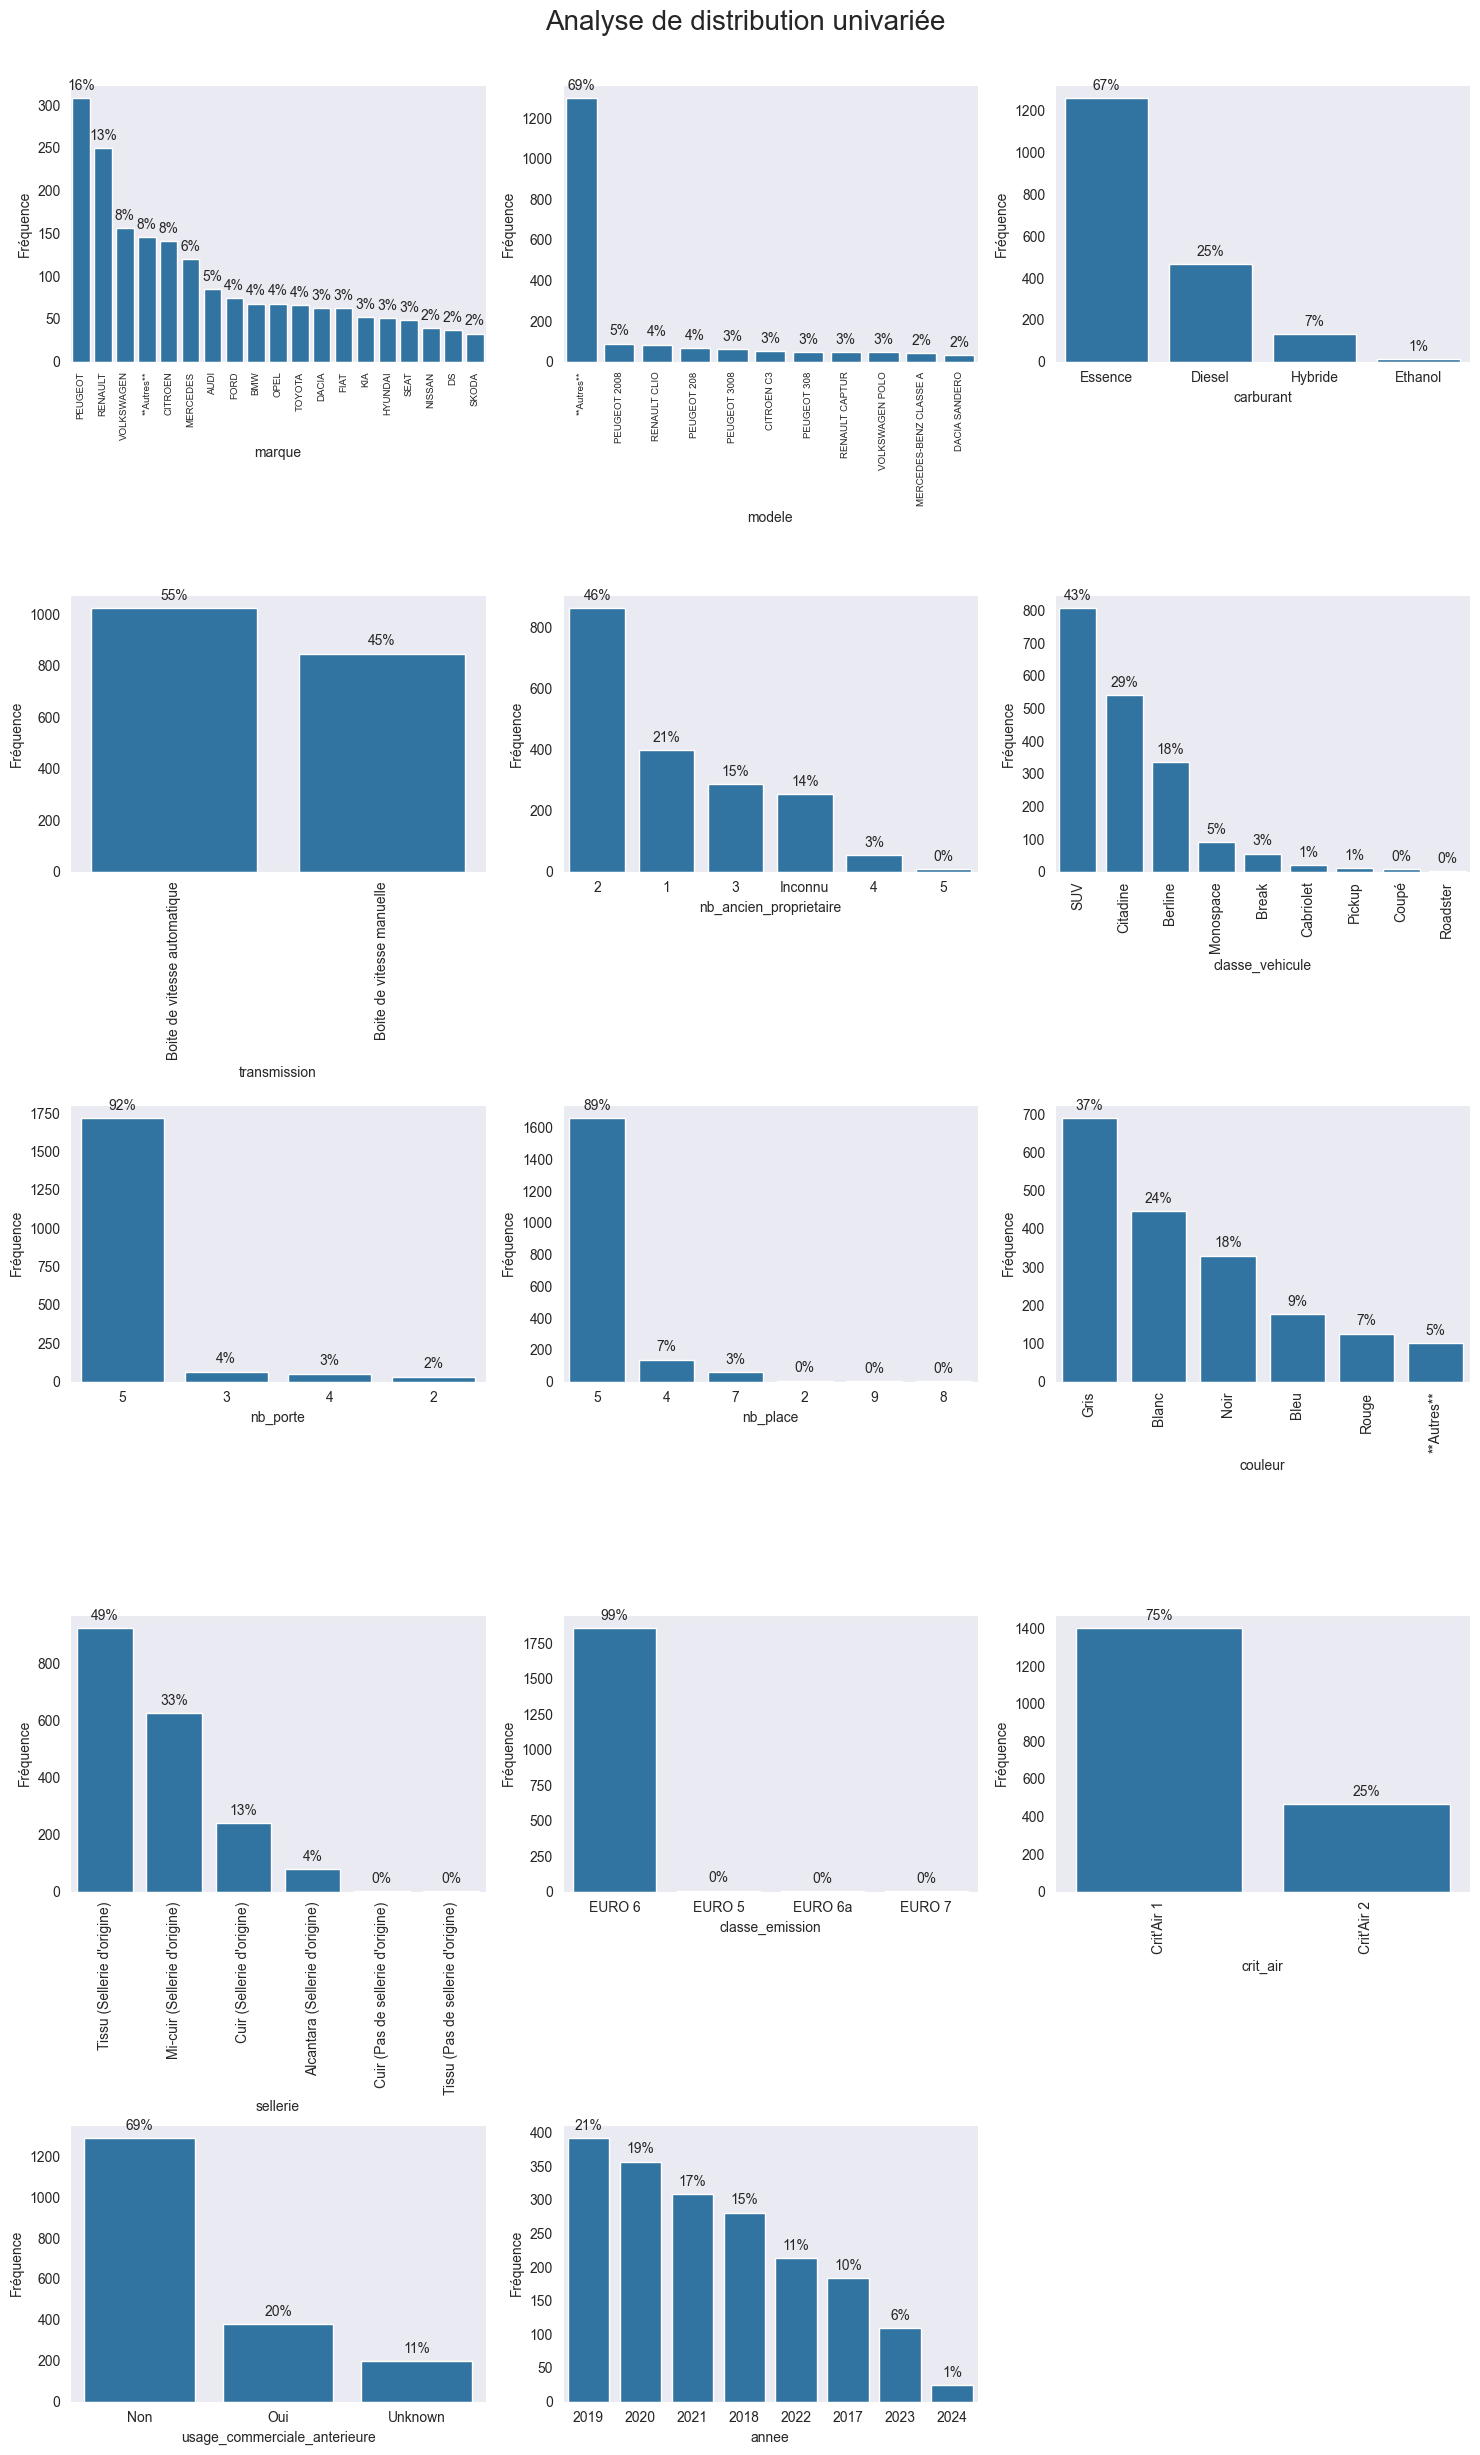

In [44]:
univariate_analysis(X_train, list_columns=categorical_variables, dtype="cat")

<u><b> Conclusion </b></u>:  
N.B: "Autres" = regroupement des modalités qui ont moins de 30 observations, quand il y a plus de 10 catégories
- Marque: Il y a 34 marques différentes dans le dataset. La majorité contient des marques françaises: Peugeot, Renault  
- Modèle: 221 modèles différents toutes marques comprises. Pas forcément un certain modèle qui domine la répartition
- Carburant:  Il y a 4 types de carburant recensés dans le dataset. La grande majorité est "Essence" avec 67% des obs, suivie par "Diesel" (25%). Hybride et Ethanol représentent peu. Pas Electrique dans le dataset.  
- Boite de vitesse: assez équilibré entre Automatique et Manuelle, avec des fréquences relativement plus hautes en boite Automatique  
- Nombre d'ancien propriétaire: 1 ou 2 anciens propriétaies en général  
- Classe véhicule: la majorité est SUV, Citadine, Berline  
- Nombre de porte & nombre de place: presque à 5 portes & 5 places  => assez traditionnel  
- Couleur: Gris, Blanc et Noir sont majoritaires
- Sellerie: Tissu ou Mi-cuir en général
- Classe d'émisison: presque la totalité est EURO-6
- Critair: la grande majorité est en Critair 1, le reste en Critair 2  => Voitures relativement au norme  
- Usage commerciale antérieure: Non dans 70% des cas
- Année de mise en circulation: la majorité est entre 2018 et 2021, très peu de fréquence sur les années récentes (2023, 2024)

#### b. Variables continues

In [45]:
# Liste des variables continues, y compris la variable cible
continuous_variables = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Supprimer des variables qui ne sont pas pertinentes pour l'analyse univariée
to_drop = ['id_annonce']
continuous_variables = [col for col in continuous_variables if col not in to_drop]

print(f"Liste des variables continues: {continuous_variables}")

Liste des variables continues: ['prix', 'kilometrage', 'puissance', 'emission_CO2', 'age_days', 'age_years', 'age_months', 'km_per_year', 'km_per_month', 'prix_neuf']


               count          mean           std     min           25%  \
prix          1869.0  17624.403424   6747.831671  6890.0       12490.0   
kilometrage   1869.0  57883.333333    25355.3691   527.0       38176.0   
puissance     1869.0    127.991439      38.98719    65.0         100.0   
emission_CO2  1869.0    121.849412     23.736354    23.0         110.0   
age_days      1869.0   1810.543071    625.115296   146.0        1395.0   
age_years     1869.0      4.959551      1.712334     0.4           3.8   
age_months    1869.0     60.351418     20.836722     4.9          46.5   
km_per_year   1869.0  12173.527715   5317.570799   251.0        8613.6   
km_per_month  1869.0    1000.46549    437.211894    20.6         709.8   
prix_neuf     1869.0  30654.701721  10934.915065  9990.0  22051.764706   

                  50%      75%      max  
prix          16390.0  21190.0  45590.0  
kilometrage   59649.0  79392.0  99987.0  
puissance       125.0    150.0    340.0  
emission_CO2    1

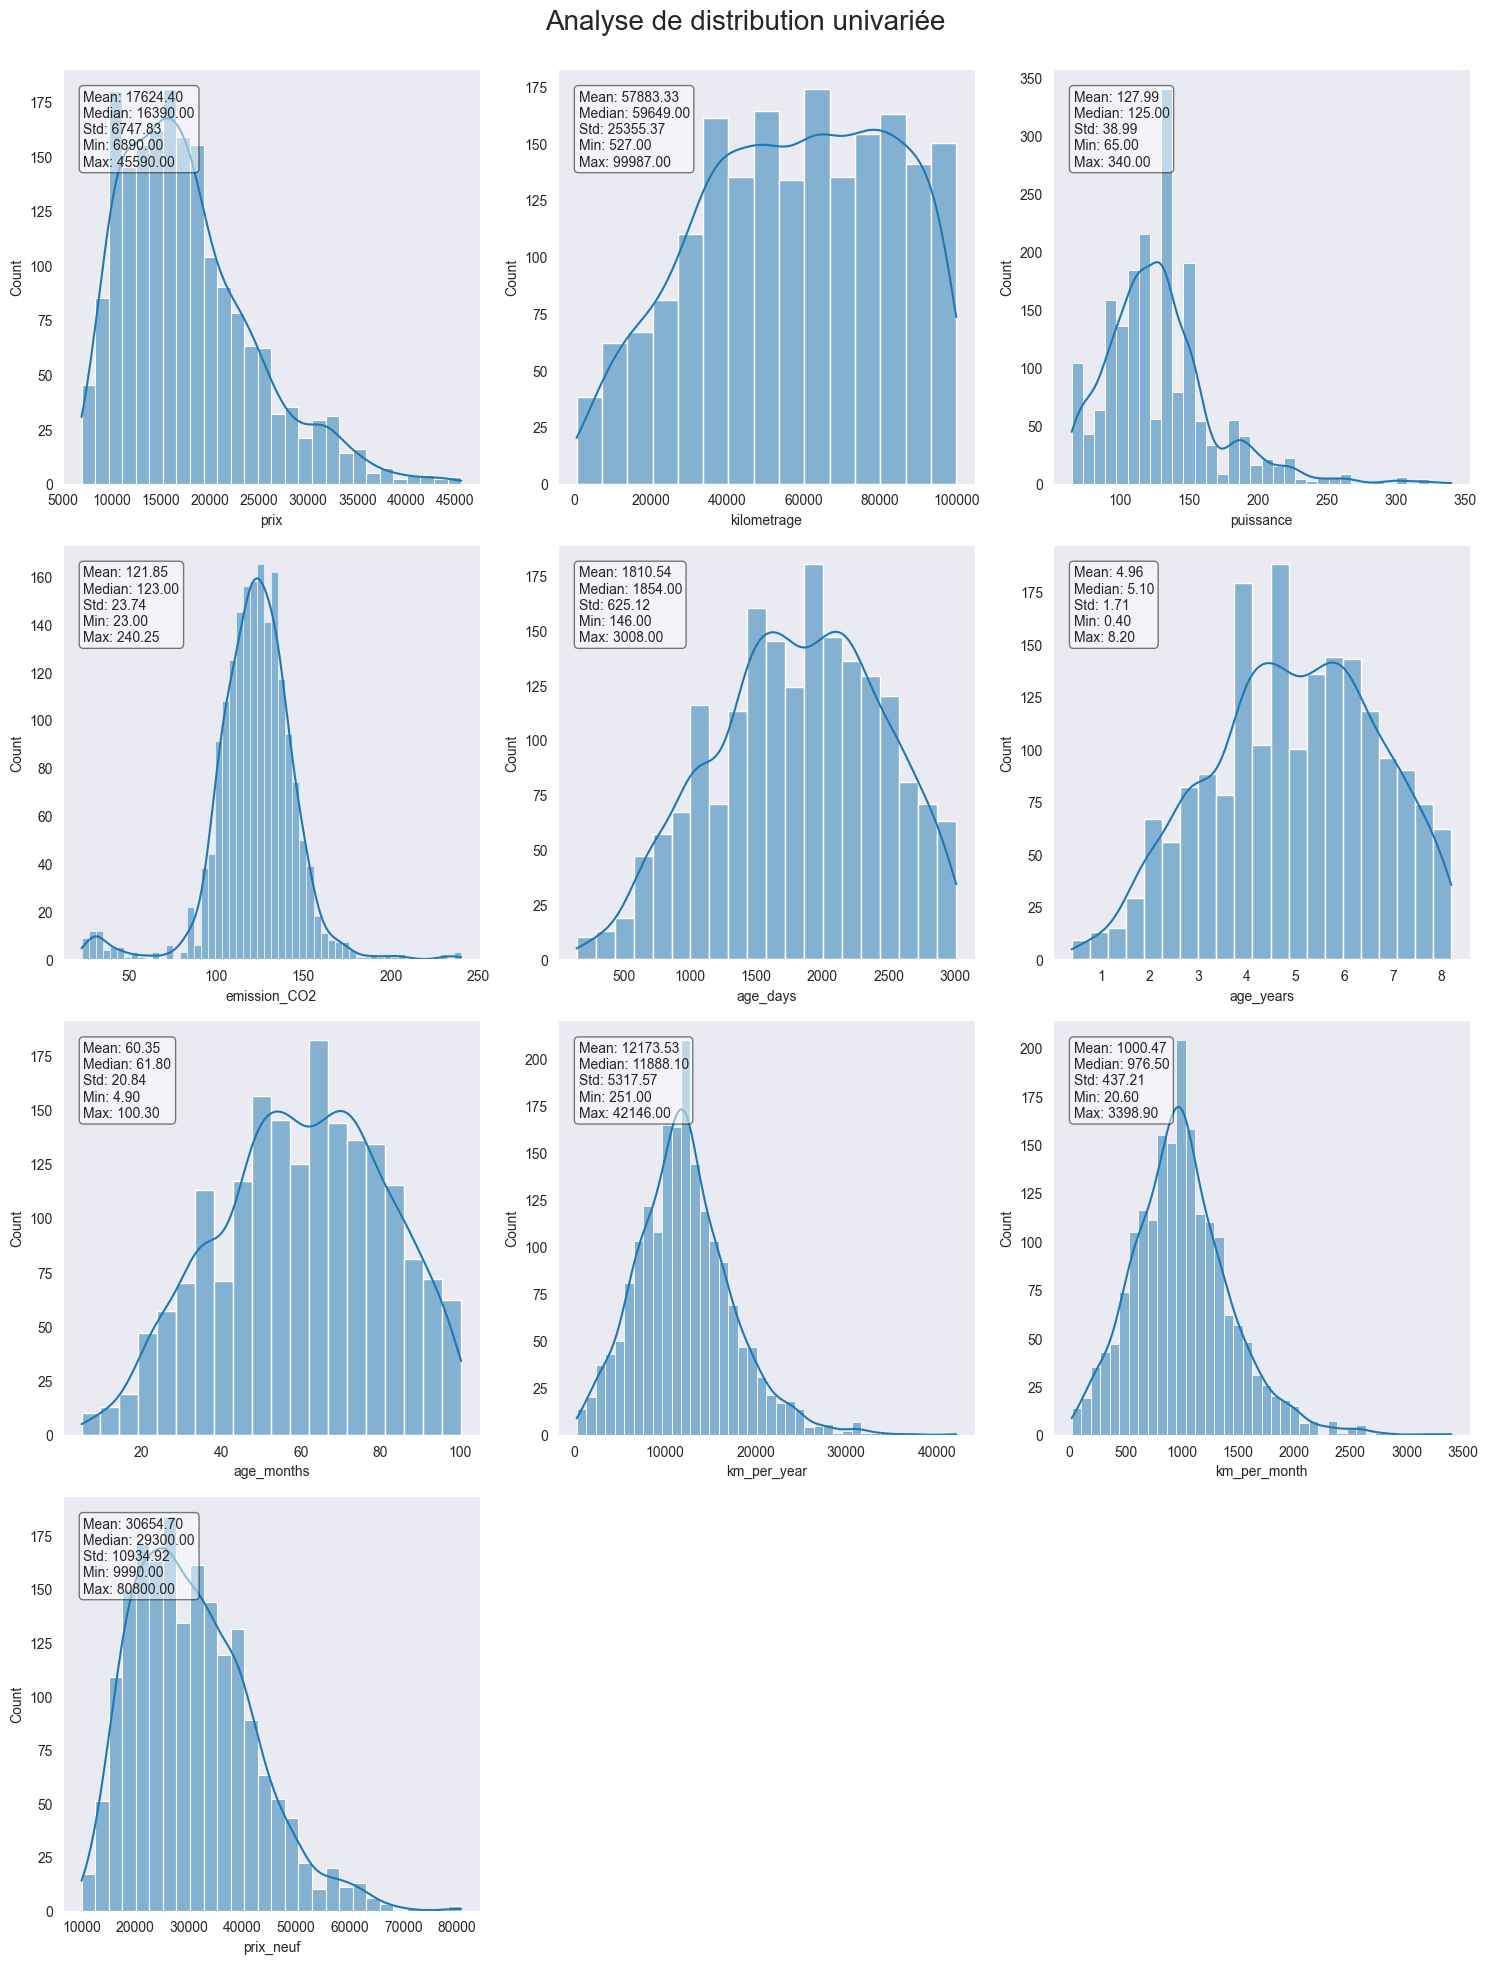

In [46]:
univariate_analysis(X_train, list_columns=continuous_variables, dtype="num")

La distribution de prix d'occasion est relativement asymétrique à droite, avec une moyenne autour de 17K€  
Par construction lors de la collecte des données, le kilométrage est borné à 100K km. Année de mise en circulation est floorée à 2017   
Le ratio VR moyen est aux alentours de 58% et celui-ci est proche de la médiane

### 2. Target vs variables catégorielles

Statistiques de Target value pour marque :
            count      mean       std       min       25%       50%       75%  \
marque                                                                          
DACIA        63.0  0.825534  0.091007  0.651253  0.779708  0.816336  0.895923   
ABARTH        7.0  0.744125  0.051716  0.670633  0.708241  0.772898  0.782416   
SUZUKI       21.0  0.723932  0.077330  0.595601  0.668516  0.740342  0.771066   
SMART         3.0  0.723343  0.038368  0.697778  0.701284  0.704790  0.736126   
MG            1.0  0.714150       NaN  0.714150  0.714150  0.714150  0.714150   
CUPRA         3.0  0.679574  0.070042  0.613372  0.642906  0.672439  0.712674   
TOYOTA       66.0  0.667187  0.090676  0.495565  0.608382  0.660723  0.701915   
VOLKSWAGEN  156.0  0.651343  0.090466  0.436537  0.588590  0.649292  0.724359   
SKODA        33.0  0.643611  0.078796  0.515009  0.577011  0.624777  0.710687   
SEAT         49.0  0.639152  0.070557  0.522407  0.587657  0.62921

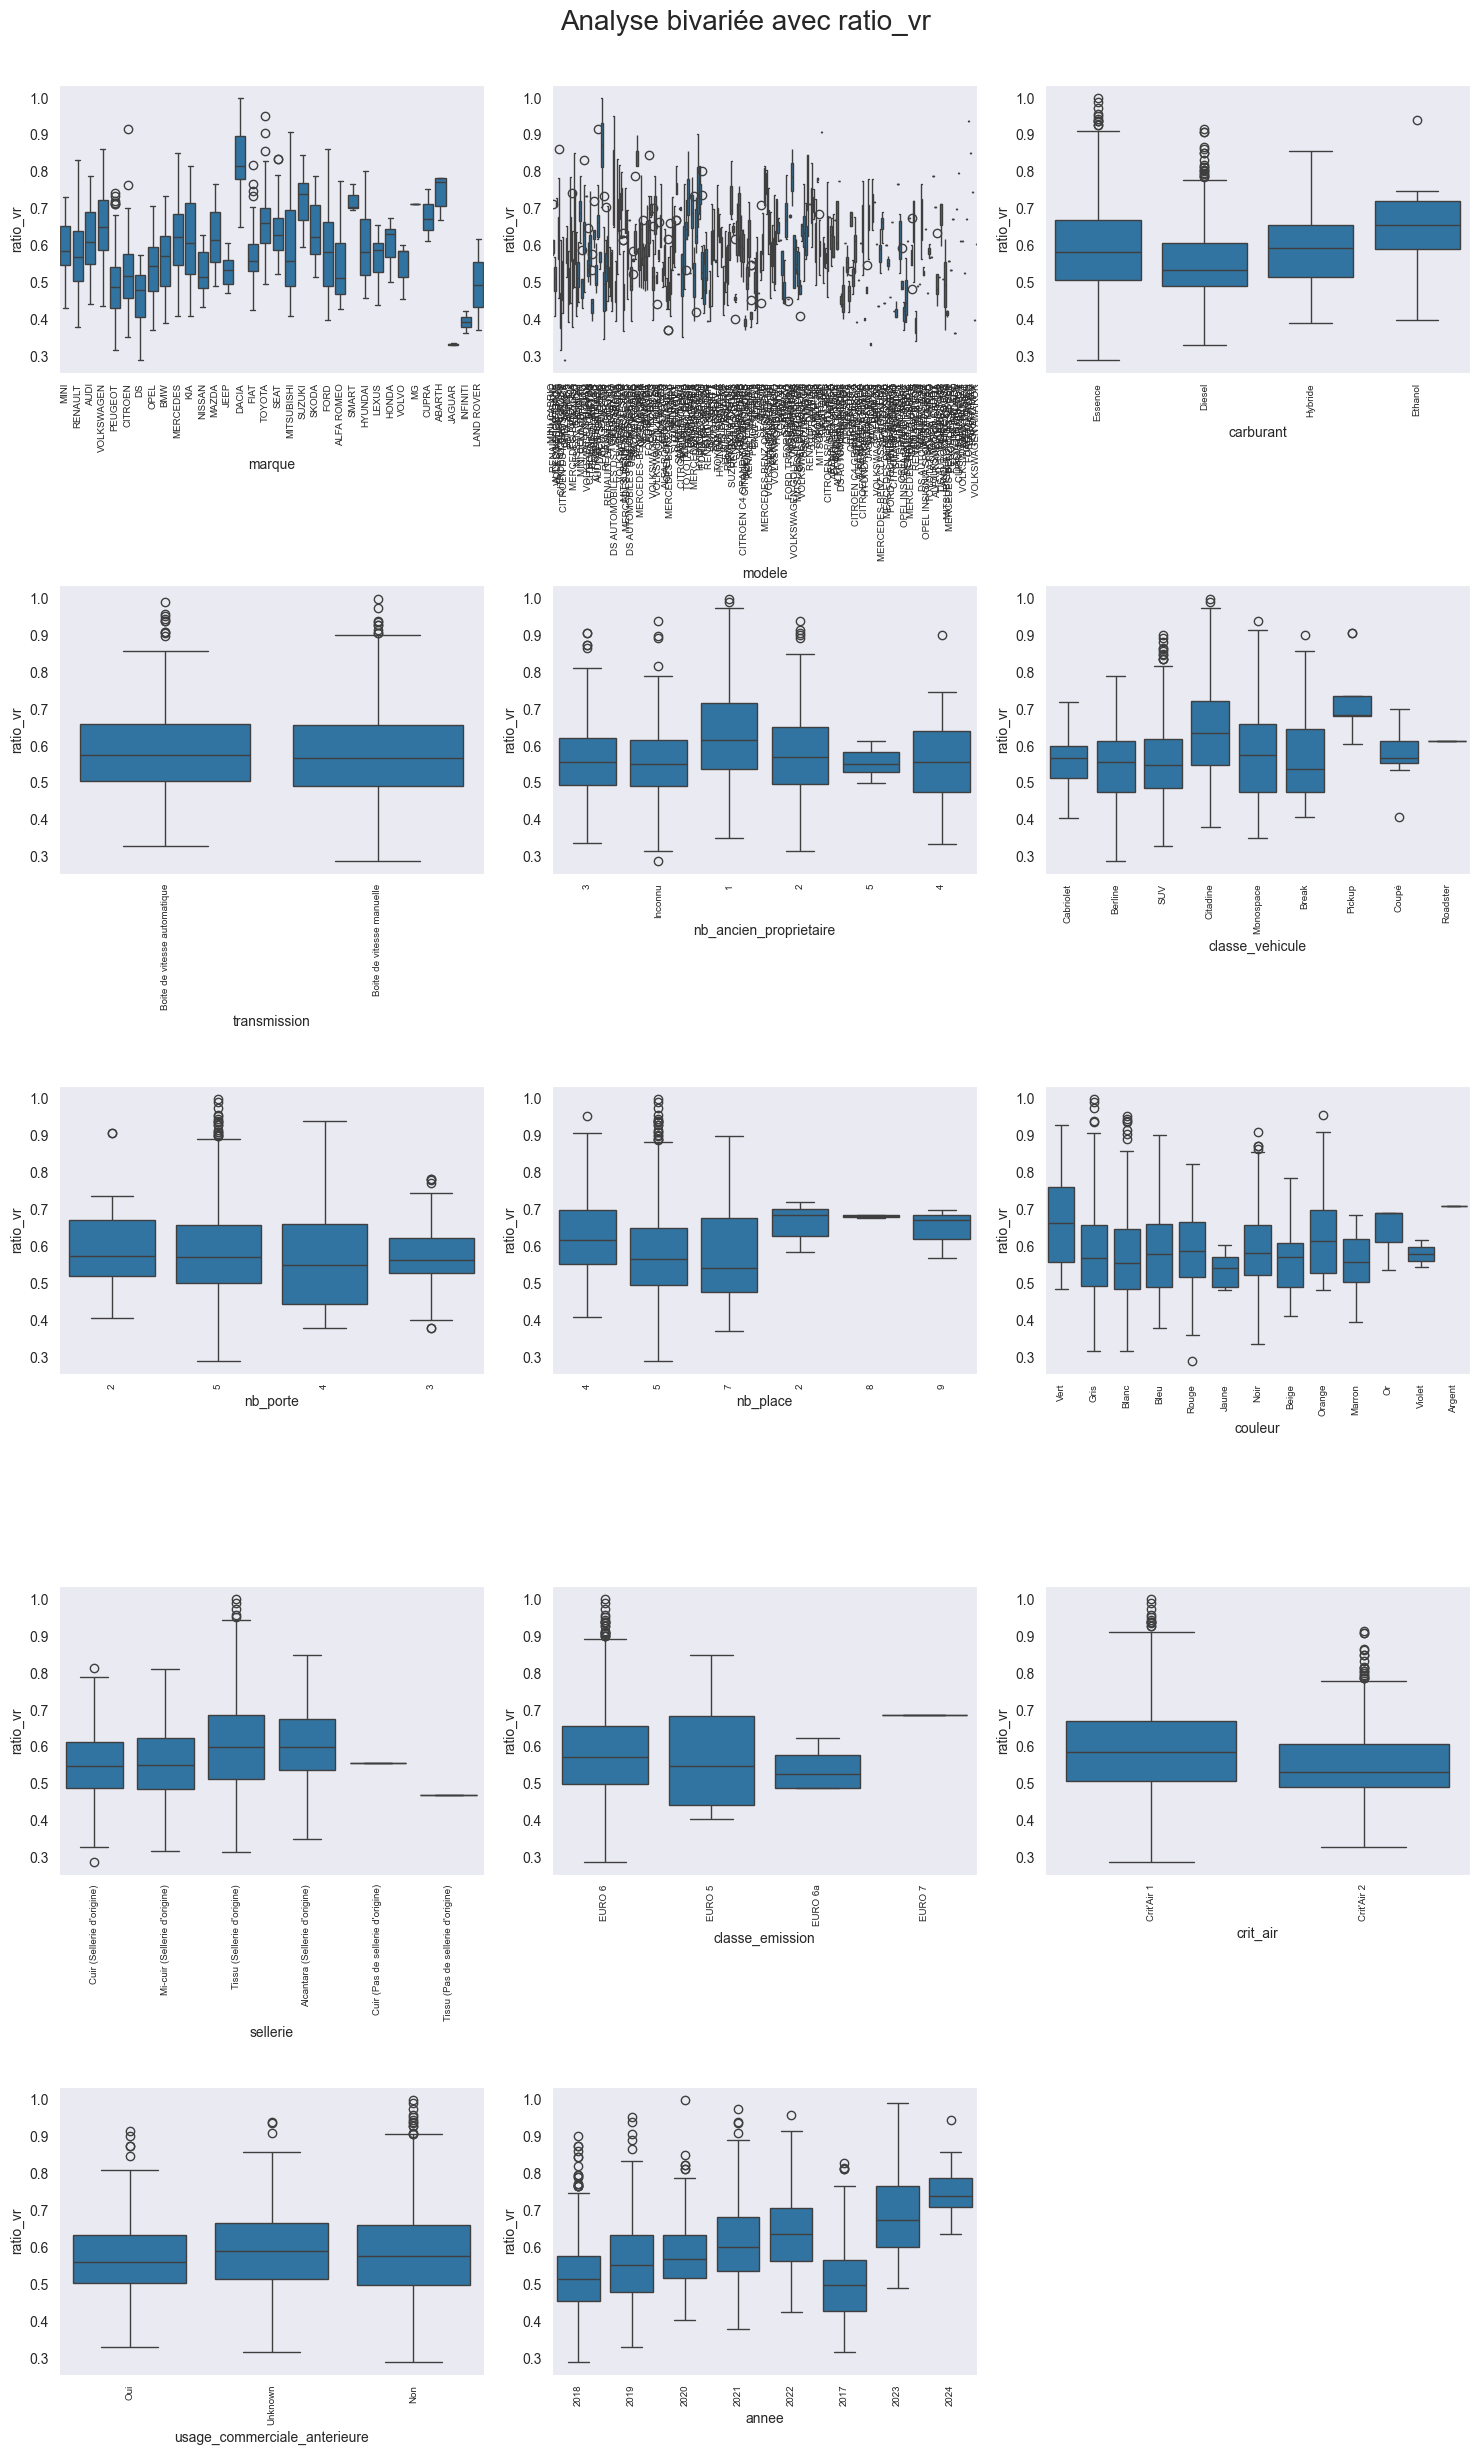

In [47]:
# Rassembler X_train et y_train pour l'analyse bivariée
X_y_train = pd.concat([X_train, y_train], axis=1) 
bivariate_analysis(X_y_train, list_columns=categorical_variables, dtype="cat", target_column=target_variable)

Les marques et modèles sont nombreux => Besoin potentiel de les regrouper ?  
Le taux de VR est moyennement plus élevé sur les voitures d'essence que diesel  
Il n'y a pas forcément d'écart significatif de ratio VR moyen entre les voitures de boite auto et de boite manuelle dans cet échantillon  
Les voitures qui ont 1 ancien propriétaire uniquement se vendent généralement plus cher  

                             count unique                           top  freq
marque                        1869     34                       PEUGEOT   308
modele                        1869    217                  PEUGEOT 2008    89
carburant                     1869      4                       Essence  1259
transmission                  1869      2  Boite de vitesse automatique  1023
nb_ancien_proprietaire        1869      6                             2   865
classe_vehicule               1869      9                           SUV   807
nb_porte                      1869      4                             5  1717
nb_place                      1869      6                             5  1660
couleur                       1869     13                          Gris   690
sellerie                      1869      6    Tissu (Sellerie d'origine)   923
classe_emission               1869      4                        EURO 6  1858
crit_air                      1869      2                    Cri

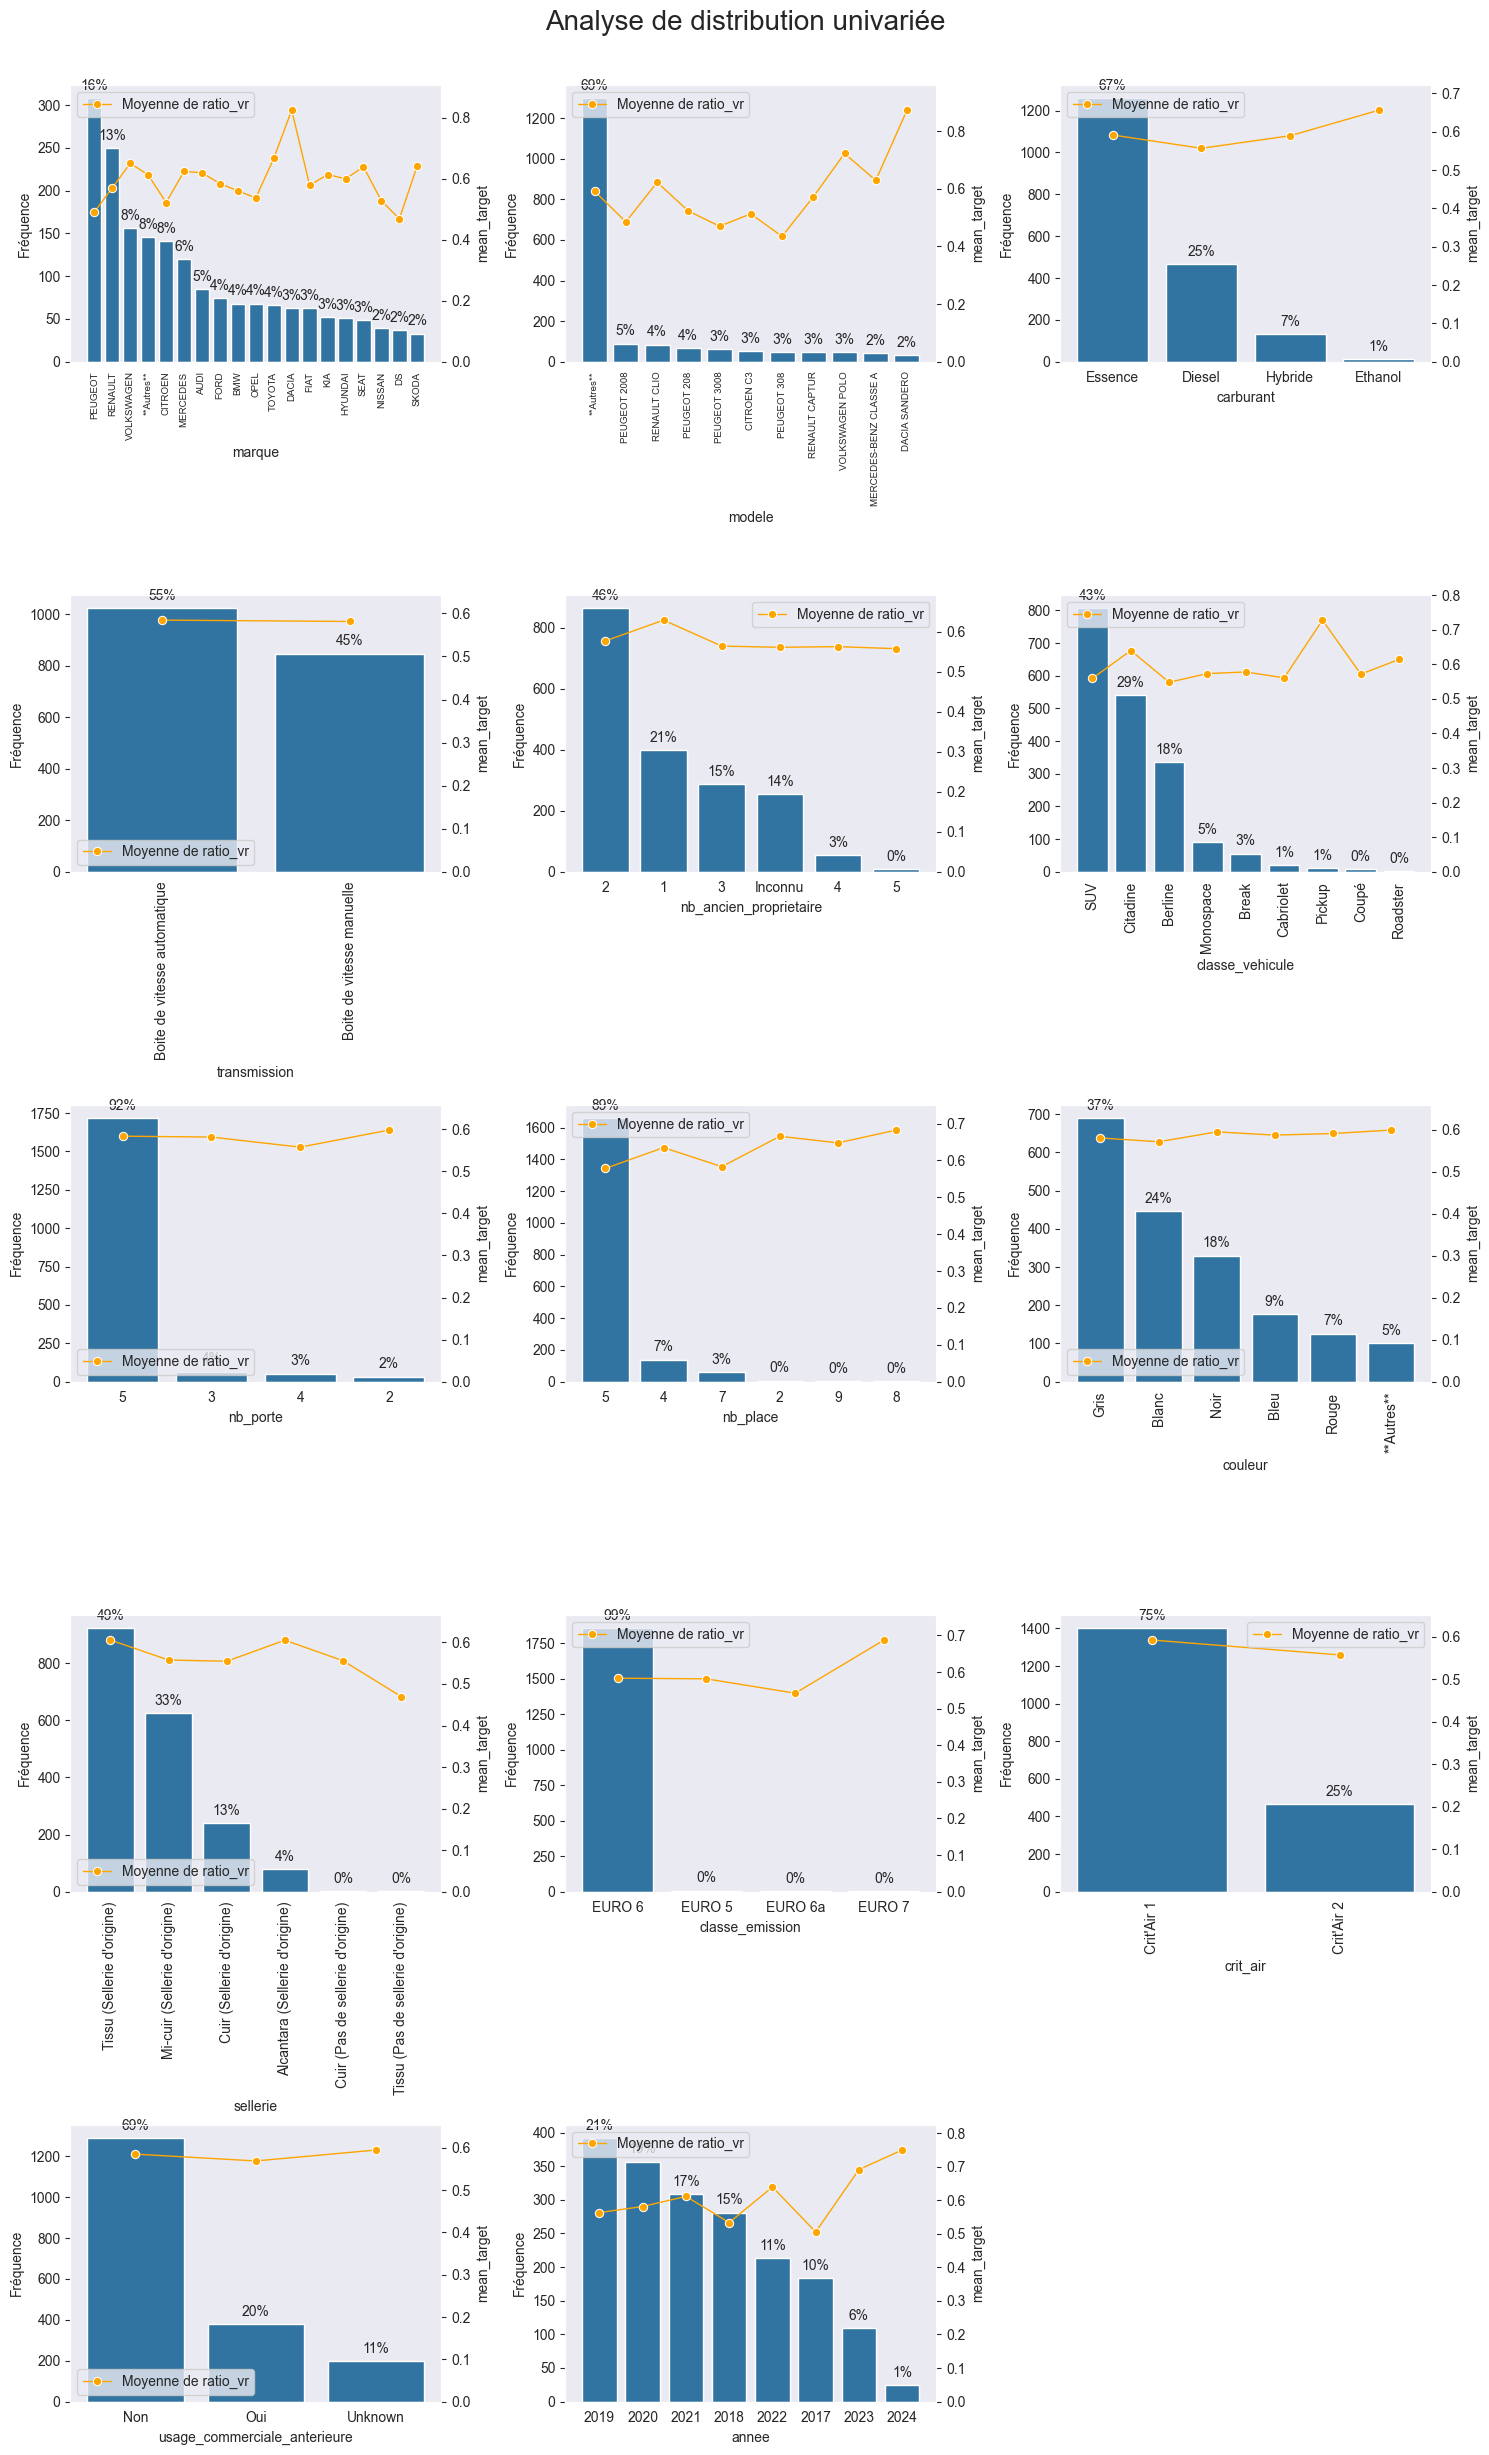

In [48]:
univariate_analysis(X_y_train, list_columns=categorical_variables, dtype="cat", target_column=target_variable)

La répartition des modalités au sein des variables comme: nb_place, nb_porte, classe_emission 
n'est pas équilibre. Forte concentration sur une modalité

In [49]:
# Regrouper les types de sellerie, ne prendre que la matière = élément avant la parenthèse
X_train['sellerie'] = X_train['sellerie'].str.split('(').str[0].str.strip()
print(f"Liste de sellerie après le regroupement: {sorted(set(X_train['sellerie']))}")

# Appliquer pour X_test
X_test['sellerie'] = X_test['sellerie'].str.split('(').str[0].str.strip()
print(f"Liste de sellerie après le regroupement pour l'échantillon de test: {sorted(set(X_test['sellerie']))}")

# Appliquer pour X_y_train
X_y_train['sellerie'] = X_y_train['sellerie'].str.split('(').str[0].str.strip()
print(f"Liste de sellerie après le regroupement pour l'échantillon de XY train: {sorted(set(X_y_train['sellerie']))}")

Liste de sellerie après le regroupement: ['Alcantara', 'Cuir', 'Mi-cuir', 'Tissu']
Liste de sellerie après le regroupement pour l'échantillon de test: ['Alcantara', 'Cuir', 'Mi-cuir', 'Tissu']
Liste de sellerie après le regroupement pour l'échantillon de XY train: ['Alcantara', 'Cuir', 'Mi-cuir', 'Tissu']


### 3. Target vs variables continues

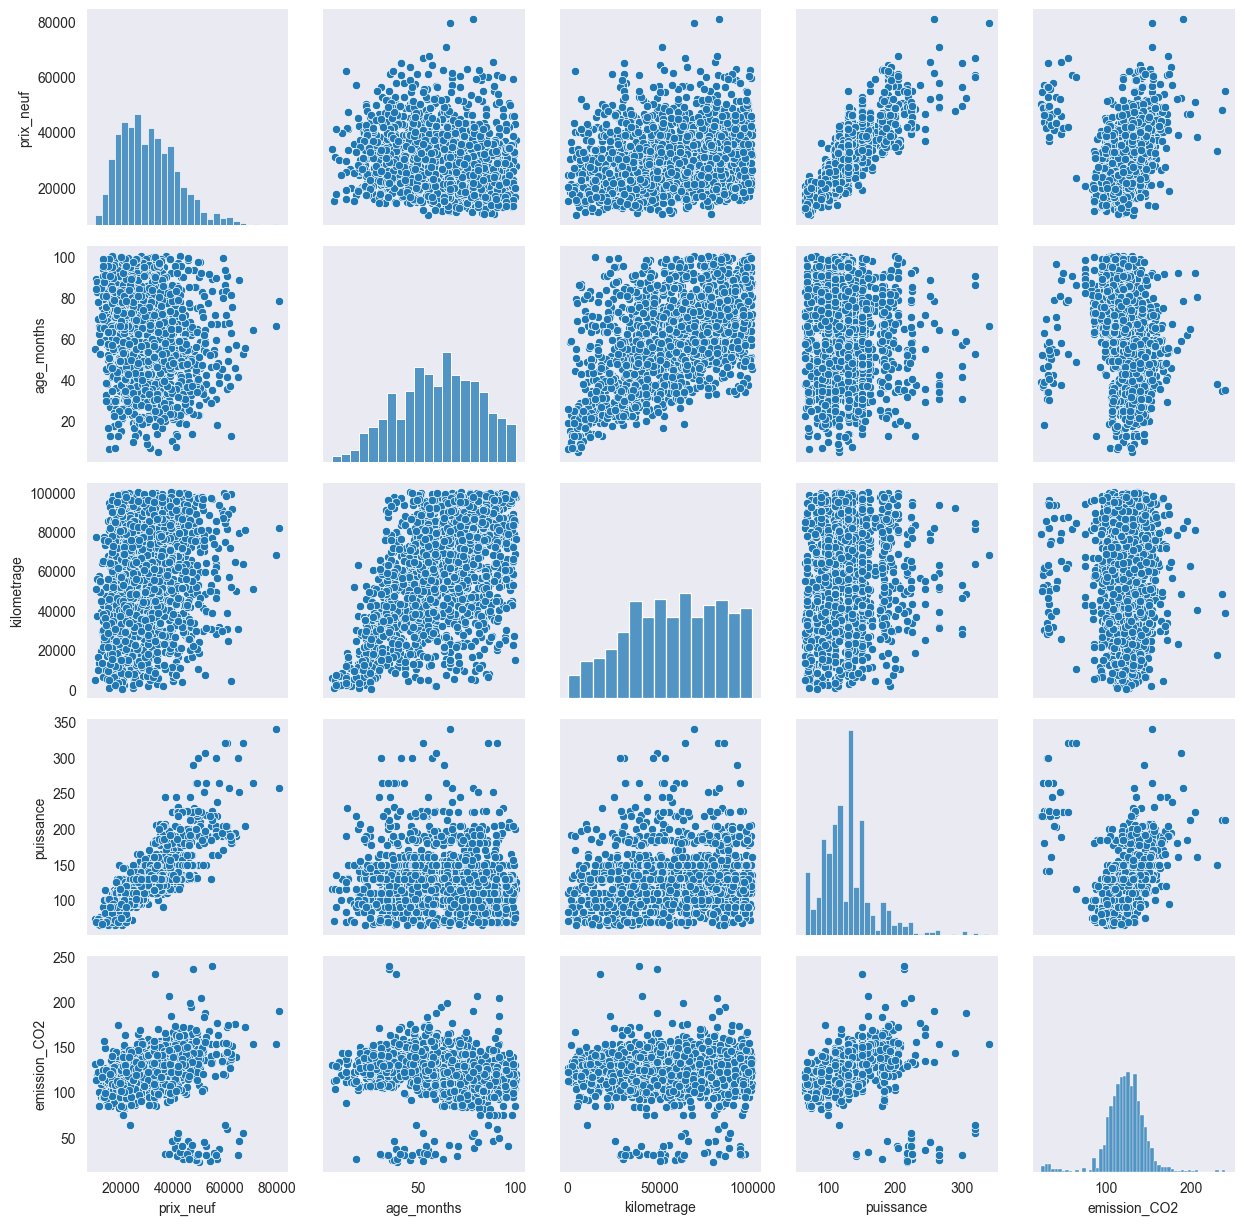

In [50]:
num_var_focus = ['prix_neuf', 'age_months', 'kilometrage', 'puissance', 'emission_CO2']
g = sns.PairGrid(X_y_train, vars=num_var_focus)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.fig_size = (8, 12)

Top 5 modèles: ['PEUGEOT 2008', 'RENAULT CLIO', 'PEUGEOT 208', 'PEUGEOT 3008', 'CITROEN C3']


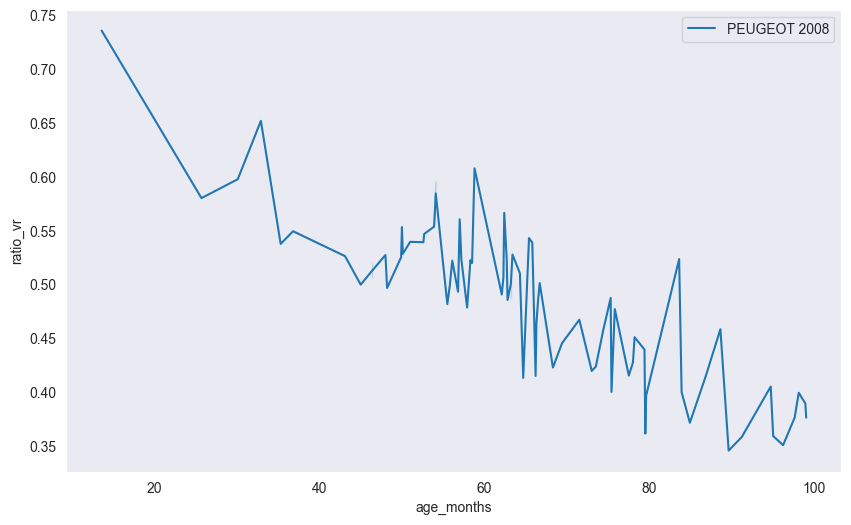

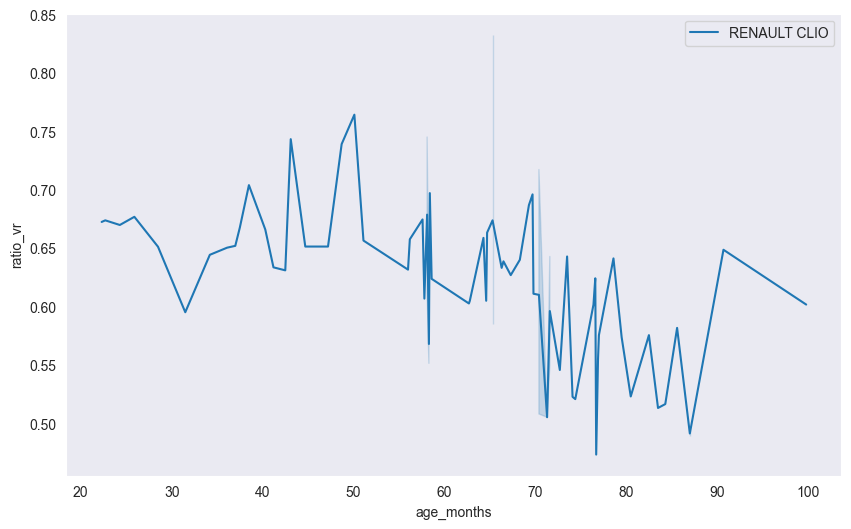

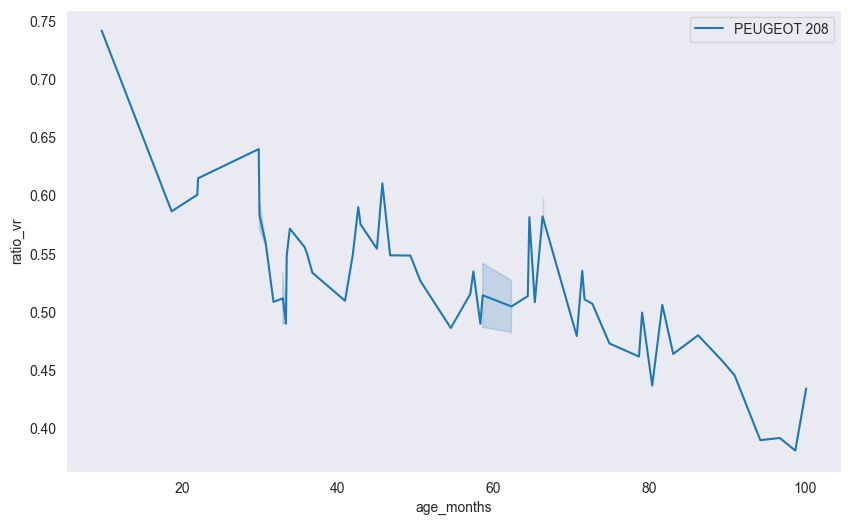

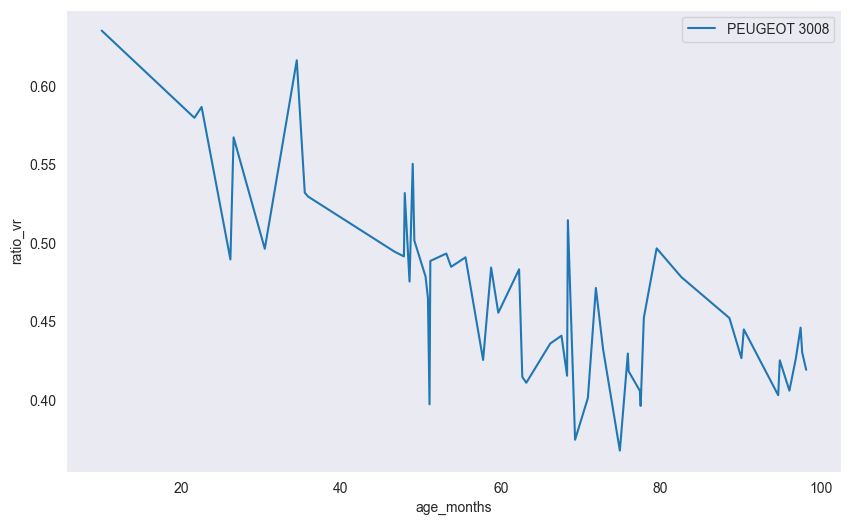

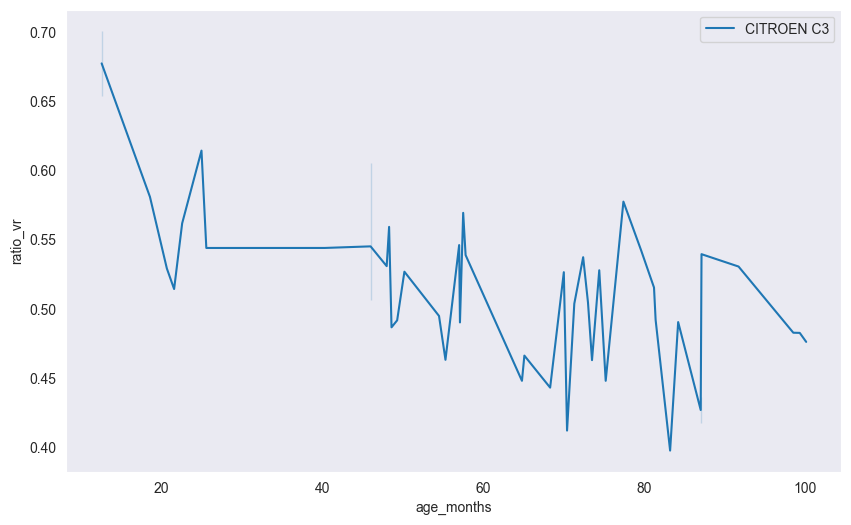

In [245]:
top_modele = X_y_train["modele"].value_counts().nlargest(5).index.tolist()
print(f"Top 5 modèles: {top_modele}")

for i in top_modele:
    data = X_y_train[(X_y_train["modele"]==i)]
    plt.subplots(figsize=(10, 6))
    sns.lineplot(x=data['age_months'], y=data[target_variable], label=i)

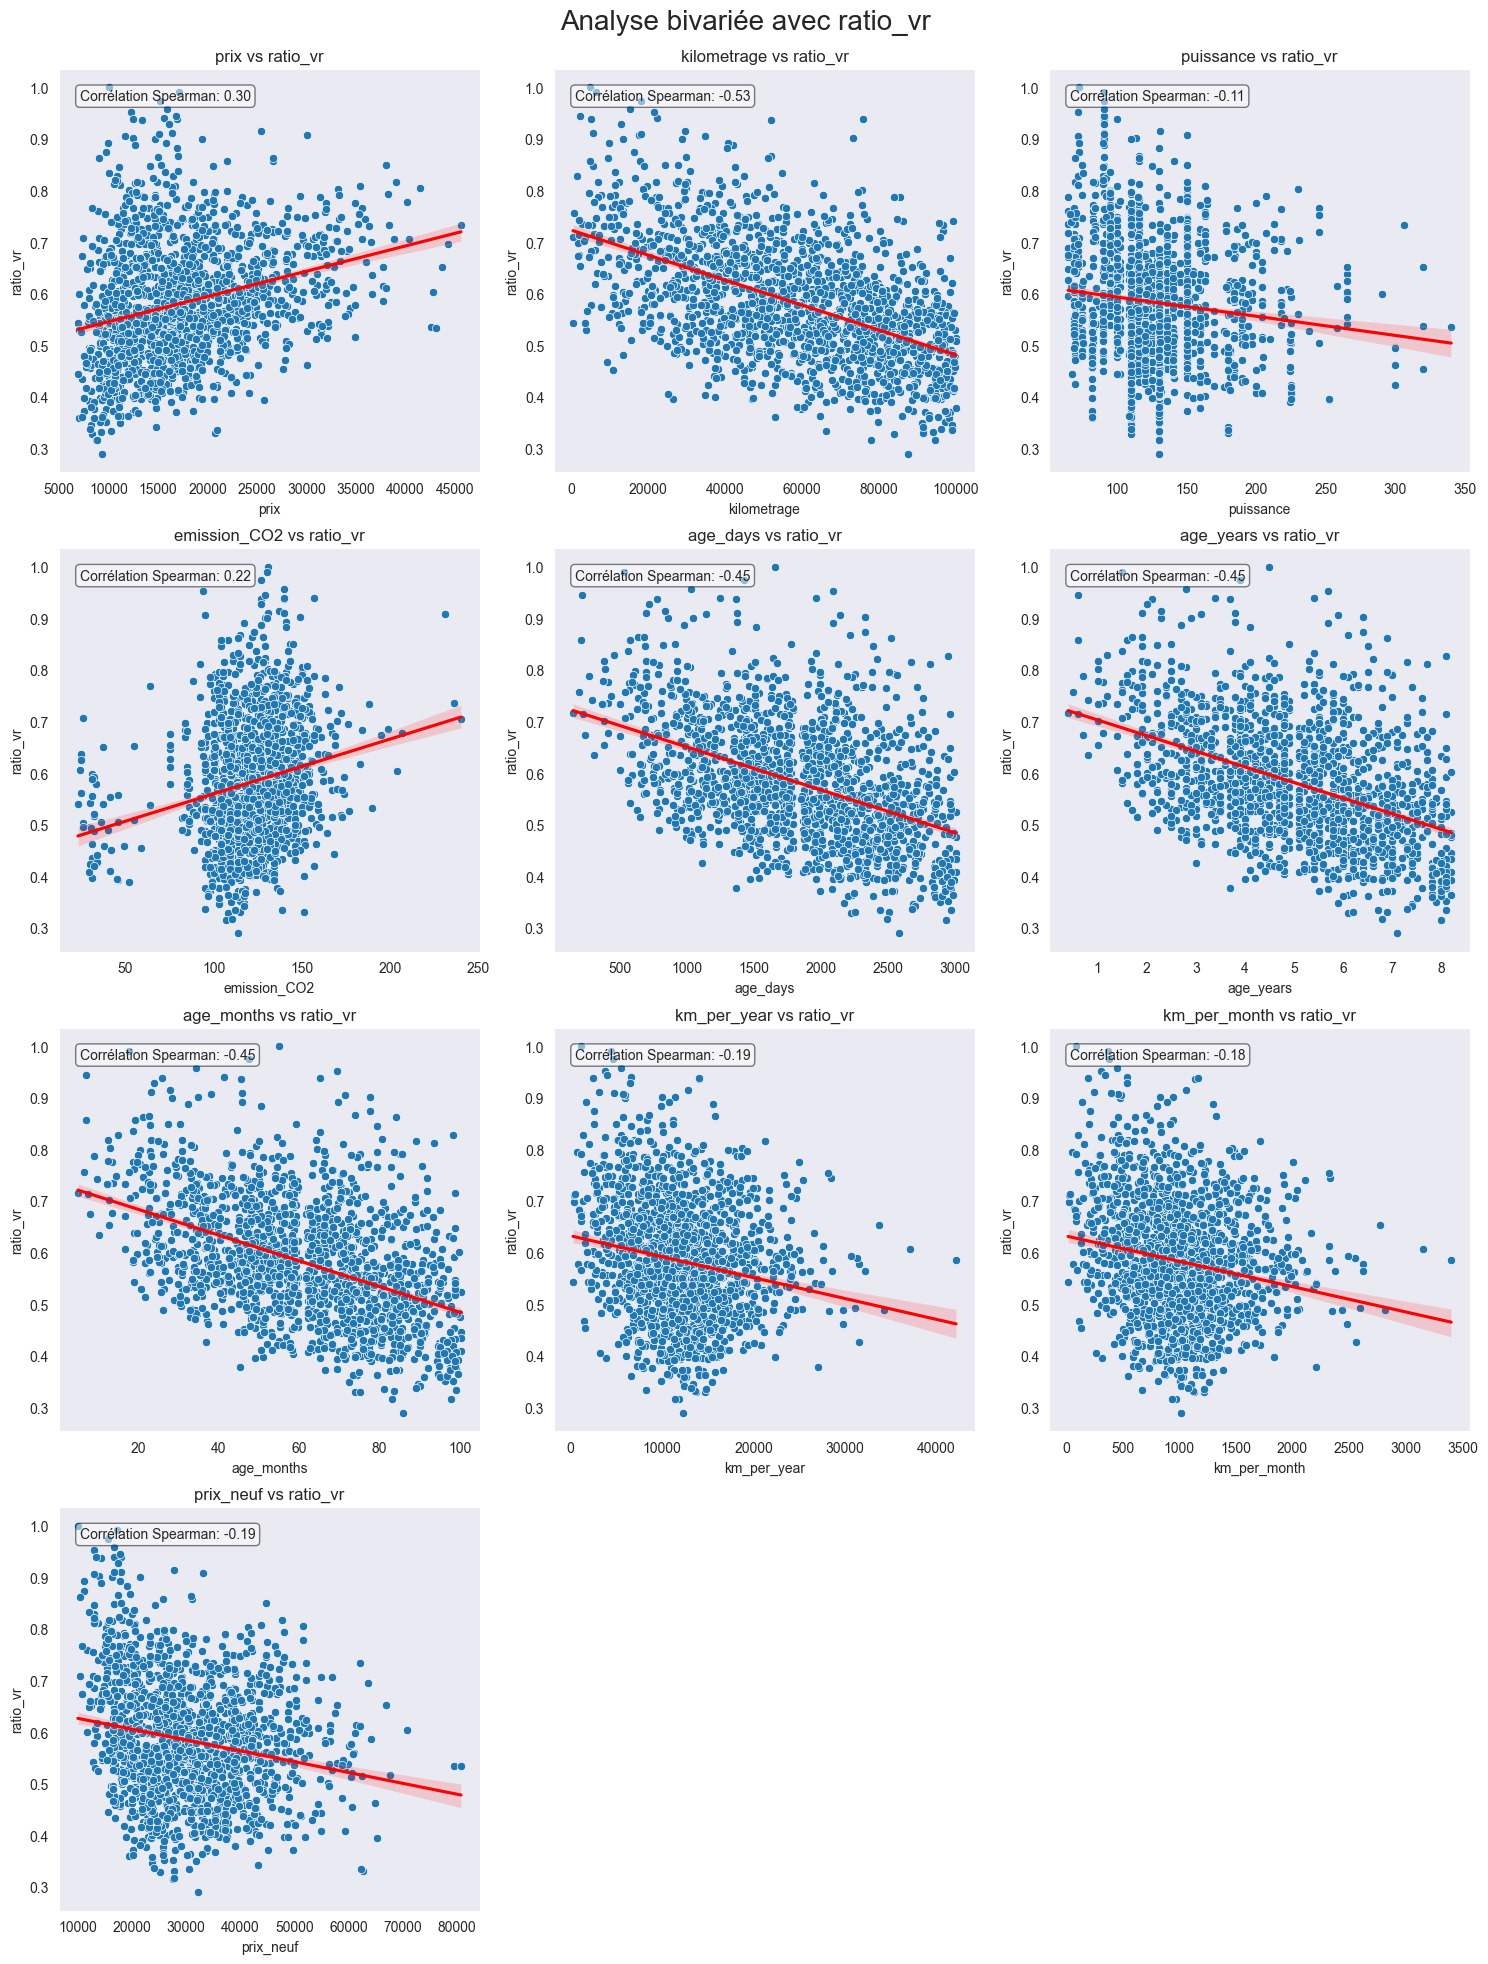

In [51]:
bivariate_analysis(X_y_train, list_columns=continuous_variables, dtype="num", target_column=target_variable)

### 4. Analyses multivariées

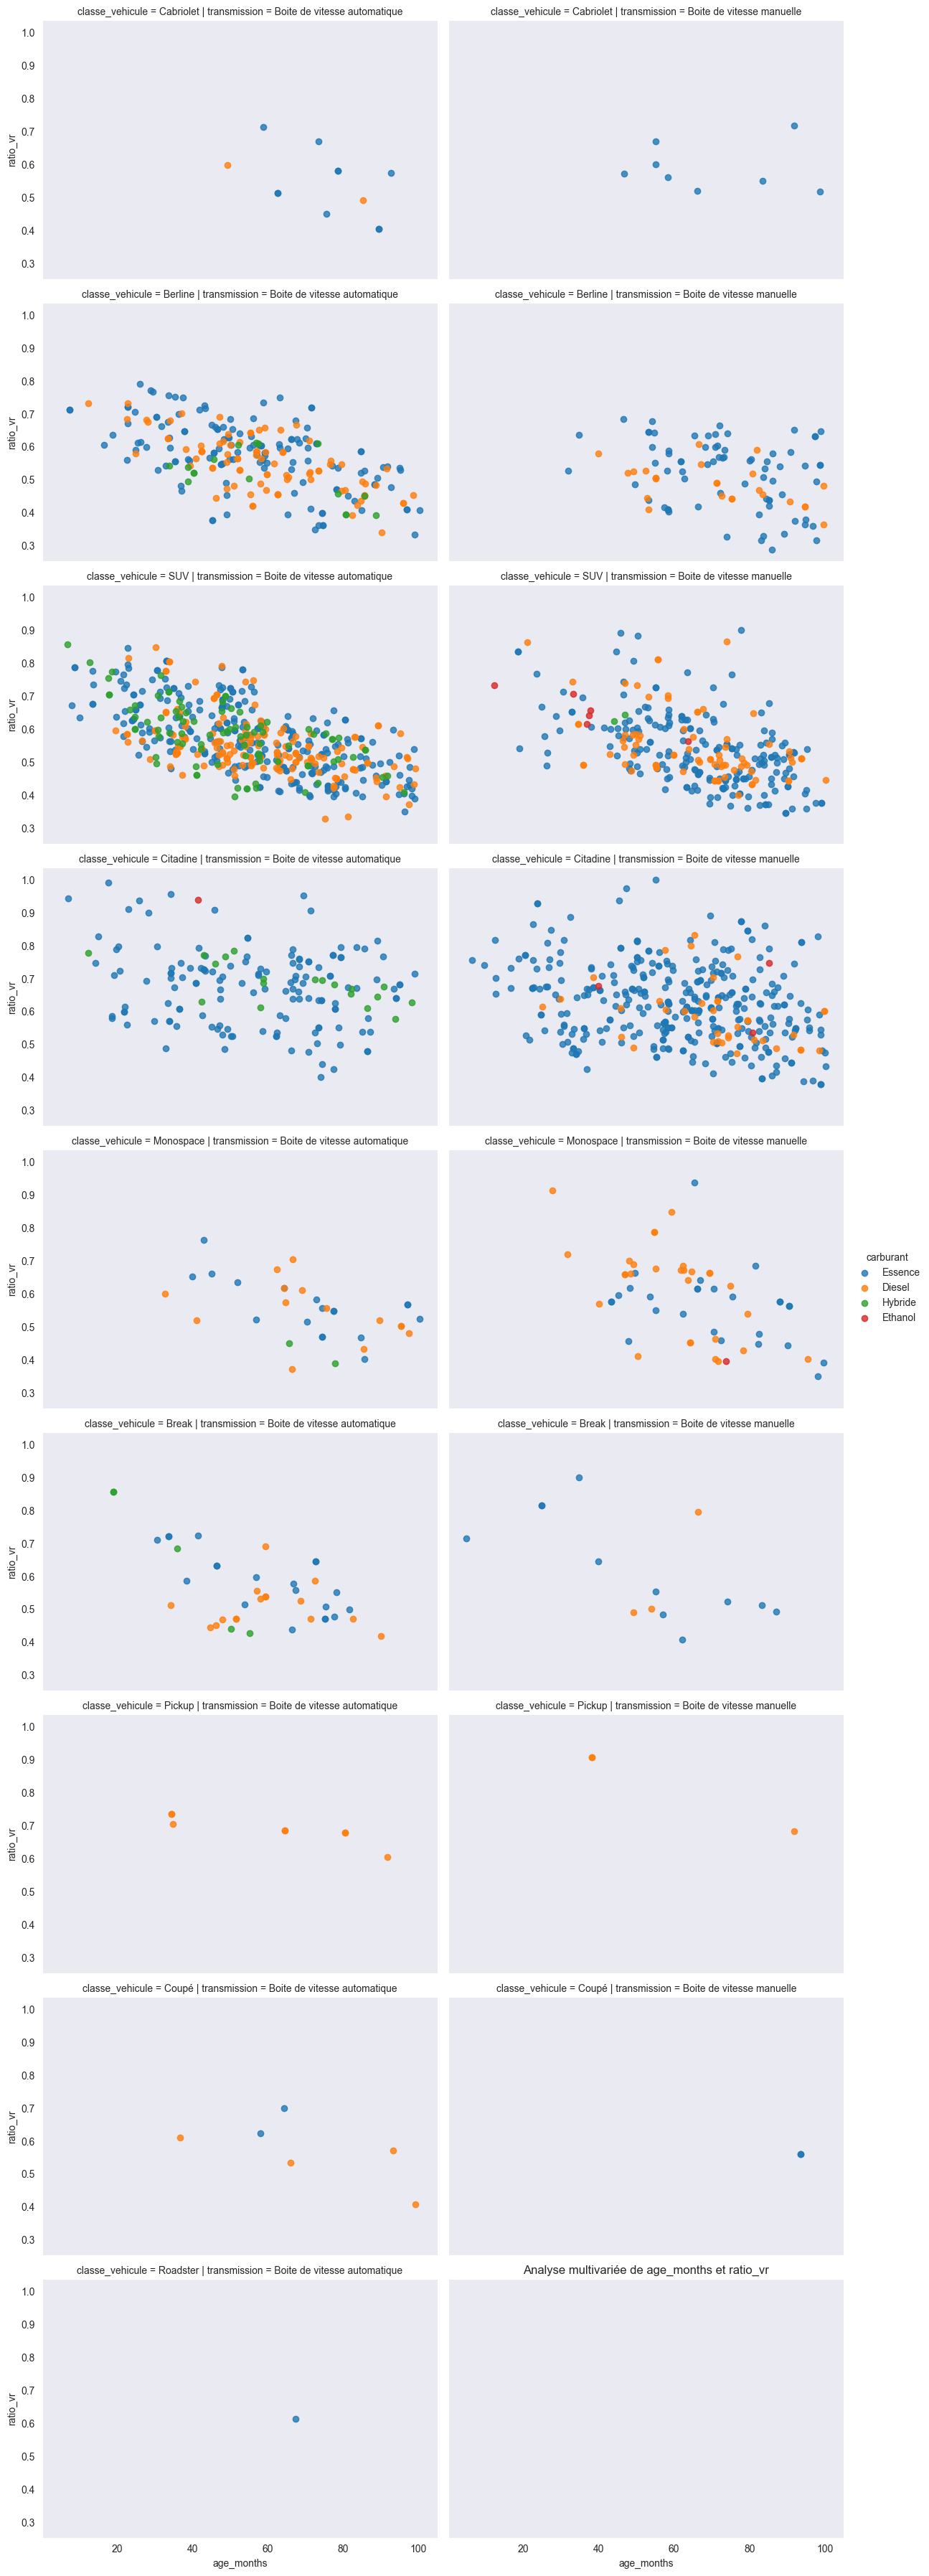

In [52]:
# VR par l'âge du véhicule et classe de véhicule
multivariate_analysis(X_y_train, x="age_months", y = target_variable, 
                      row="classe_vehicule", col="transmission", hue="carburant")

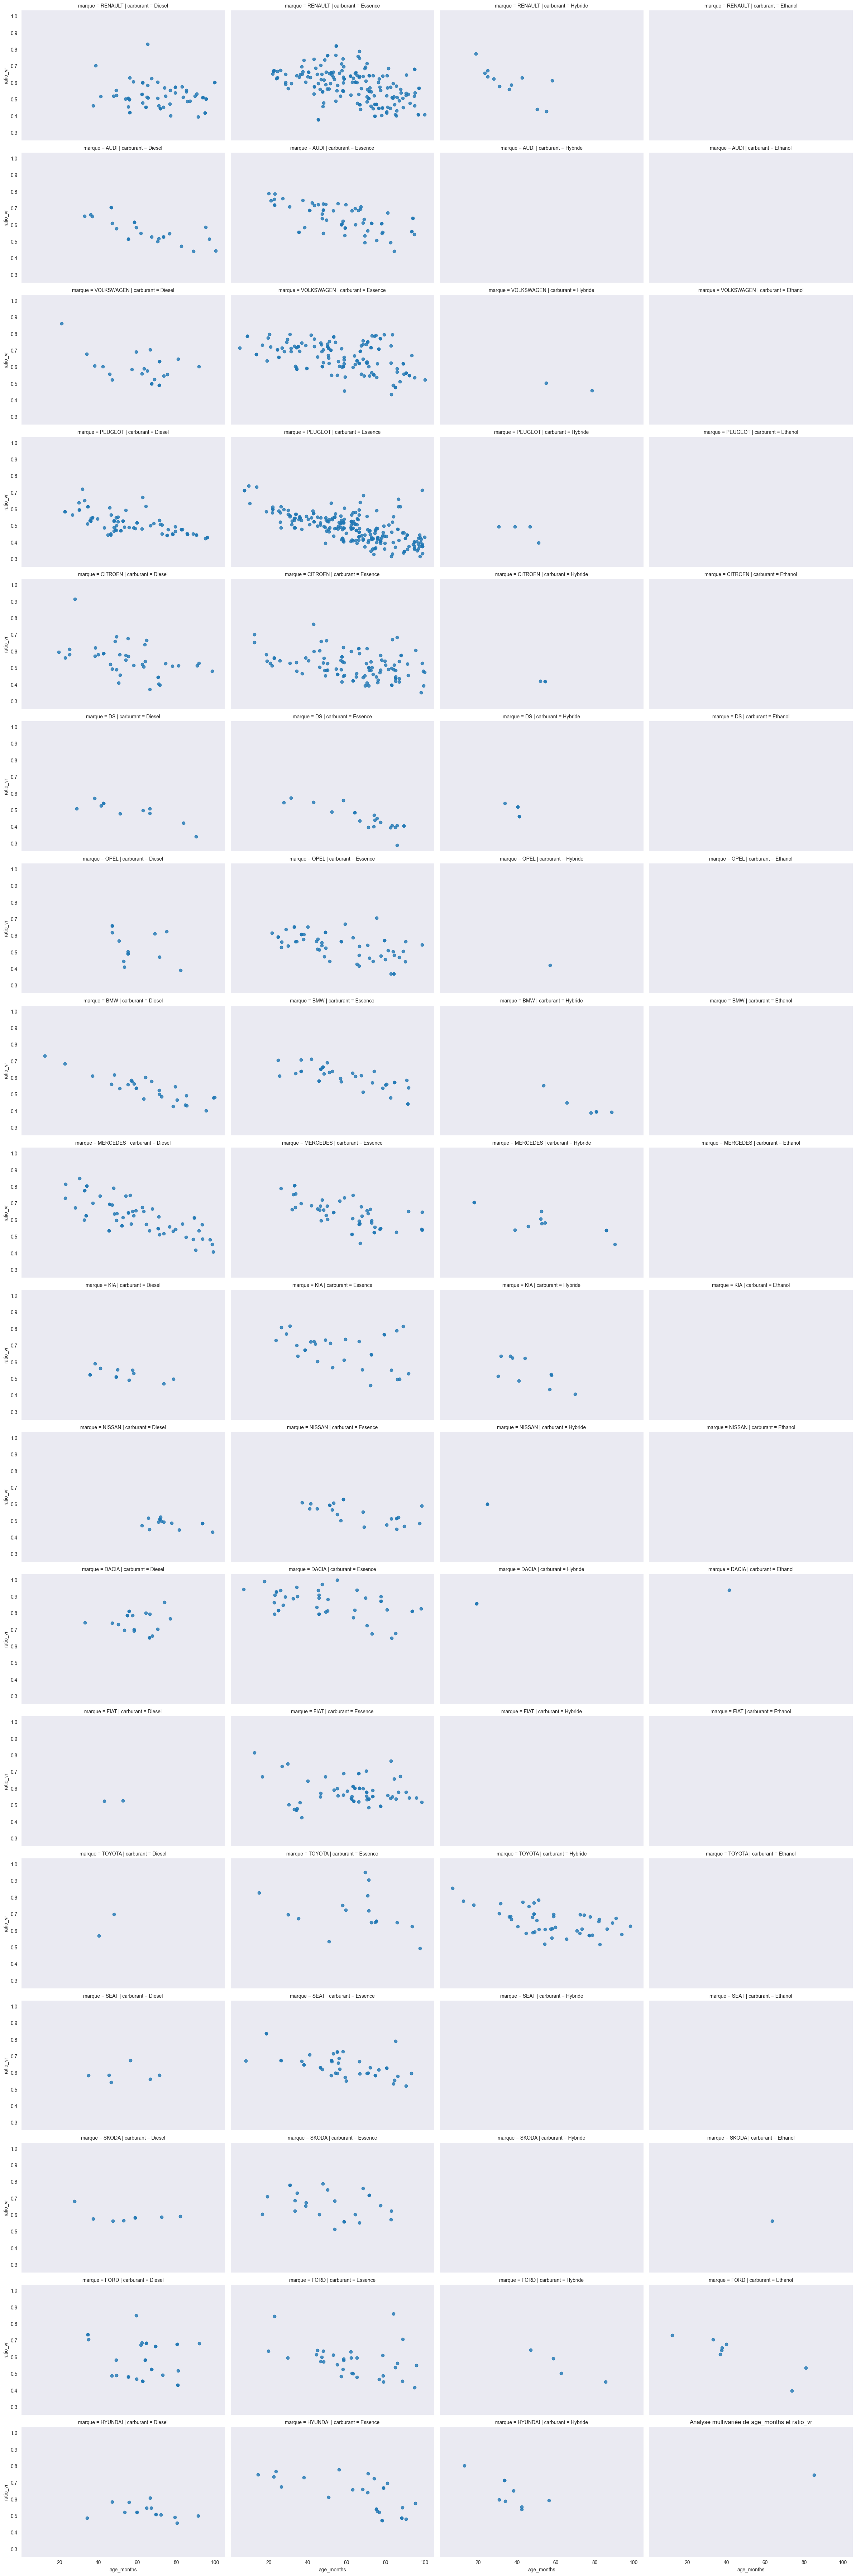

In [53]:
# Dynamique de VR en fonction de la marque, carburant et age
# Focus sur les marques qui ont plus de 30 annonces
X_y_train['marque_count'] = X_y_train.groupby('marque')['id_annonce'].transform('count')
X_y_train_30 = X_y_train[X_y_train['marque_count'] > 30]
multivariate_analysis(X_y_train_30, x="age_months", y = target_variable, 
                      row="marque", col="carburant")

In [54]:
# Graphique de 3 dimensions avec Plotly: ratio_vr, age_months et kilometrage
scatter_3d(X_y_train, x="age_months", y="kilometrage", z=target_variable,
           x_title ="Age (mois)", y_title="Kilometrage (km)", z_title="Ratio VR", legend_title="Carburant", 
           color="carburant")

En général, Ratio VR en baisse avec l'augmentation de kilométrage parcouru et de l'âge du véhicule  
- Les véhicules Diesel sont plutôt anciens et de haut kilométrage.  
- A rappeler néanmoins la forte répartition des véhicules d'essence dans ce jeu de données

In [55]:
# Age et kilométrage moyen par type de carburant
agg_df_carb = X_y_train.groupby("carburant").agg(nb_annonce = ("id_annonce", "count"),
                                                       age_month_moyen = ("age_months", "mean"),
                                                       km_moyen = ("kilometrage", "mean"),
                                                       vr_moyen = ("ratio_vr", "mean")
                                                     )
agg_df_carb.insert(agg_df_carb.columns.get_loc("nb_annonce") + 1, 
                   "nb_annonce_pct", 
                   (agg_df_carb['nb_annonce']/agg_df_carb["nb_annonce"].sum()))
agg_df_carb.sort_values(by="nb_annonce_pct", ascending=False)

nb_annonce  nb_annonce_pct  age_month_moyen      km_moyen  vr_moyen
carburant                                                                     
Essence          1259        0.673622        60.686656  53792.506751  0.591535
Diesel            467        0.249866        61.859529  70119.811563  0.556830
Hybride           132        0.070626        52.738636  54367.378788  0.589636
Ethanol            11        0.005886        49.309091  48794.363636  0.656317

In [56]:
# Graphique de 3 dimensions avec Plotly: ratio_vr, age_months et prix_neuf
scatter_3d(X_y_train, x="age_months", y="prix_neuf", z=target_variable,
           x_title ="Age (mois)", y_title="Prix neuf", z_title="Ratio VR", legend_title="Carburant", 
           color="carburant")

In [57]:
# Graphique de 3 dimensions avec Plotly: ratio_vr, kilometrage et prix_neuf
scatter_3d(X_y_train, x="kilometrage", y="prix_neuf", z=target_variable,
           x_title ="Kilometrage (km)", y_title="Prix neuf", z_title="Ratio VR", legend_title="Carburant", 
           color="carburant")

## V. Corrélation

In [58]:
X_y_train_corr = X_y_train.drop(columns=["id_annonce", "annee", "marque_count", "prix"])
cat_var_xy = X_y_train_corr.select_dtypes(include=['object']).columns.tolist()

In [59]:
# Création des dummies
df_X_y_train = pd.get_dummies(X_y_train_corr, columns = cat_var_xy, drop_first=True)

In [263]:
corr_spearman = df_X_y_train.corr(method="spearman")
corr_target = corr_spearman[target_variable]
df_corr = pd.DataFrame(corr_target)
df_corr.sort_values(by=target_variable, key=lambda x: x.abs(), ascending=False, inplace=True)
df_corr

ratio_vr
ratio_vr                    1.000000
kilometrage                -0.525694
age_months                 -0.447154
age_days                   -0.447108
age_years                  -0.446781
...                              ...
couleur_Violet              0.002518
modele_KIA STONIC          -0.002386
marque_FIAT                -0.001621
classe_vehicule_Coupé      -0.000775
modele_TOYOTA PROACE VERSO -0.000643

[305 rows x 1 columns]

- L'age et le kilométrage parcouru font partie des variables les plus discriminantes p/r au ratio VR
- La marque Peugeot a une décote plus significative que d'autres marques dans l'échantillon  
- Les véhicules de marque Dacia ont tendance de garder sa valeur dans le temps  

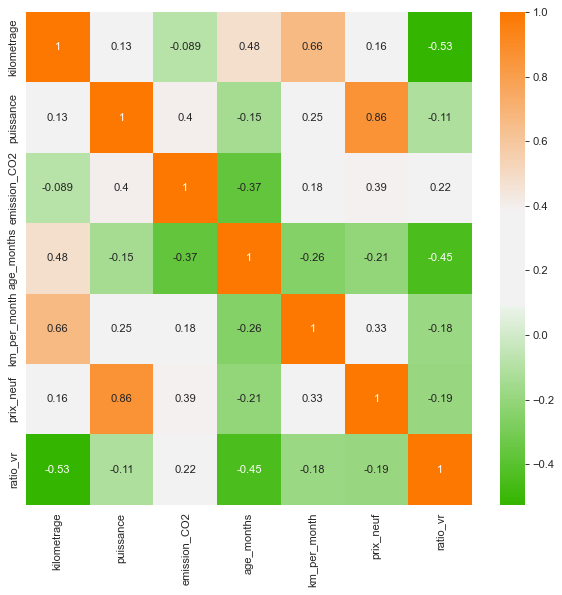

In [61]:
cmap = sns.diverging_palette(125, 28, s=100, l=65, sep=50, as_cmap=True)
fig, ax = plt.subplots(figsize=(9, 8), dpi=80)
ax = sns.heatmap(df_X_y_train[['kilometrage', 'puissance', 'emission_CO2', 'age_months',
                               'km_per_month', 'prix_neuf', target_variable]].corr(method="spearman"), annot=True, cmap = cmap)
plt.show()

## VI. Categorical Embedding

In [62]:
# Nombre d'année group by modèle
X_train["modele"].value_counts()

modele
PEUGEOT 2008         89
RENAULT CLIO         84
PEUGEOT 208          68
PEUGEOT 3008         63
CITROEN C3           51
                     ..
DACIA DOKKER          1
FORD TOURNEO          1
ABARTH 595            1
FORD C-MAX            1
VOLKSWAGEN AMAROK     1
Name: count, Length: 217, dtype: int64

In [63]:
X_y_train.groupby("modele").agg(nb_annonce = ("id_annonce", "count"),
                                nb_annee = ("annee", "nunique"),
                                age_moyen = ("age_years", "mean"),   
                                km_moyen = ("kilometrage", "mean"),
                                vr_moyen = ("ratio_vr", "mean")).sort_values(by="nb_annonce", ascending=False)

nb_annonce  nb_annee  age_moyen      km_moyen  vr_moyen
modele                                                                    
PEUGEOT 2008               89         8   5.315730  62345.426966  0.485236
RENAULT CLIO               84         7   5.023810  52032.785714  0.622406
PEUGEOT 208                68         8   4.564706  45079.397059  0.522868
PEUGEOT 3008               63         8   5.158730  68147.444444  0.469952
CITROEN C3                 51         7   5.003922  50465.411765  0.513058
...                       ...       ...        ...           ...       ...
VOLKSWAGEN CADDY            1         1   5.500000  65937.000000  0.705336
VOLKSWAGEN PASSAT           1         1   5.600000  89973.000000  0.526064
VOLKSWAGEN ARTEON           1         1   6.800000  80026.000000  0.436537
VOLVO XC40                  1         1   6.100000  97017.000000  0.514547
VOLVO XC60                  1         1   4.900000  61946.000000  0.601185

[217 rows x 5 columns]

In [64]:
X_train["marque"].value_counts()

marque
PEUGEOT       308
RENAULT       250
VOLKSWAGEN    156
CITROEN       141
MERCEDES      120
AUDI           85
FORD           74
BMW            68
OPEL           68
TOYOTA         66
DACIA          63
FIAT           63
KIA            52
HYUNDAI        51
SEAT           49
NISSAN         39
DS             37
SKODA          33
MINI           28
MAZDA          21
SUZUKI         21
JEEP           14
MITSUBISHI     11
HONDA          10
ALFA ROMEO      9
LEXUS           7
ABARTH          7
VOLVO           5
SMART           3
CUPRA           3
INFINITI        2
JAGUAR          2
LAND ROVER      2
MG              1
Name: count, dtype: int64

In [65]:
X_y_train.groupby("marque").agg(nb_annonce = ("id_annonce", "count"),
                                nb_annee = ("annee", "nunique"),
                                age_moyen = ("age_years", "mean"),   
                                km_moyen = ("kilometrage", "mean"),
                                vr_moyen = ("ratio_vr", "mean")).sort_values(by="nb_annonce", ascending=False)

nb_annonce  nb_annee  age_moyen      km_moyen  vr_moyen
marque                                                             
PEUGEOT            308         8   5.066234  58542.529221  0.491085
RENAULT            250         7   5.200400  56640.972000  0.570305
VOLKSWAGEN         156         8   4.700000  59900.160256  0.651343
CITROEN            141         8   5.039007  56628.269504  0.522455
MERCEDES           120         7   4.896667  62374.825000  0.624511
AUDI                85         7   4.870588  62225.552941  0.620149
FORD                74         8   5.000000  65371.932432  0.584555
BMW                 68         8   5.205882  62885.323529  0.560811
OPEL                68         7   4.726471  54533.720588  0.537661
TOYOTA              66         8   4.887879  51920.500000  0.667187
FIAT                63         8   5.090476  50350.269841  0.579085
DACIA               63         8   4.287302  45575.666667  0.825534
KIA                 52         7   4.451923  60262.730769  0.614318
HYUNDAI             51         8   5.005882  59761.568627  0.600256
SEAT                49         8   4.685714  53541.122449  0.639152
NISSAN              39         7   5.587179  71248.589744  0.528101
DS                  37         6   5.048649  54894.135135  0.469000
SKODA               33         6   4.306061  60346.242424  0.643611
MINI                28         7   5.407143  54026.250000  0.599894
MAZDA               21         7   4.900000  63064.523810  0.622066
SUZUKI              21         5   4.257143  42787.619048  0.723932
JEEP                14         5   5.035714  66013.142857  0.532786
MITSUBISHI          11         5   4.545455  40882.000000  0.614420
HONDA               10         5   5.290000  56911.100000  0.611098
ALFA ROMEO           9         5   5.611111  50587.888889  0.541073
ABARTH               7         4   4.971429  33045.571429  0.744125
LEXUS                7         4   5.300000  59595.142857  0.564967
VOLVO                5         3   6.380000  74503.000000  0.548836
SMART                3         2   6.900000  48155.666667  0.723343
CUPRA                3         2   2.333333  40115.666667  0.679574
LAND ROVER           2         2   6.250000  87761.500000  0.494401
JAGUAR               2         2   6.450000  95200.000000  0.332514
INFINITI             2         2   7.300000  84162.500000  0.392822
MG                   1         1   2.500000  37140.000000  0.714150

Il serait intéressant de regrouper les modèles homogènes et pareillement pour les marques:  
- Réduire la dimension: on a 217 modèles différents dans le dataset => Beaucoup de modalités en one hot encoding alors que les données ne sont pas forcément représentatives sur qq uns. En plus, one-hot encoding ne permet pas de voir la similarité entre les différents modèles  
- Gérer les nouveaux modèles de voiture qui ne sont pas encore dans le dataset actuel

In [66]:
embed_features = ['marque', 'modele']
categorical_features = ['carburant', 'transmission', 'classe_vehicule', 'couleur']
numerical_features = ['kilometrage', 'puissance', 'emission_CO2', 'age_months', 'prix_neuf']

# Limiter à la dimension de 2 pour les embeddings pour une meilleure visualisation
embedding_dims = {'marque': 2, 'modele': 2}

# Create model instance
model_handler = CategoricalEmbedding(
        df = X_y_train,
        embed_features=embed_features,
        categorical_features=categorical_features,
        numerical_features=numerical_features,
        embedding_dims=embedding_dims,
        target_column=target_variable,
        hidden_layers = [128],
        dropout_rates= [0.1]
    )
# Prepare data for training
X_train_array, y_train_array = model_handler.prepare_data()

In [67]:
model = model_handler.create_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics =['mae'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ marque (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ modele (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ marque_embedding    │ (None, 1, 2)      │         68 │ marque[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ modele_embedding    │ (None, 1, 2)      │        434 │ modele[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2)         │          0 │ marque_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2)         │          0 │ modele_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ carburant           │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transmission        │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classe_vehicule     │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ couleur             │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_features  │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 37)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ carburant[0][0],  │
│                     │                   │            │ transmission[0][… │
│                     │                   │            │ classe_vehicule[… │
│                     │                   │            │ couleur[0][0],    │
│                     │                   │            │ numerical_featur… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      4,864 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,495 (21.46 KB)

 Trainable params: 5,495 (21.46 KB)

 Non-trainable params: 0 (0.00 B)

None


In [68]:
# Train the model
history = model.fit(X_train_array, y_train_array,  
                    epochs=10, batch_size=32)

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1348 - mae: 0.2797
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222 - mae: 0.1168
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0183 - mae: 0.1053
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0139 - mae: 0.0929
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0107 - mae: 0.0816
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104 - mae: 0.0809
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089 - mae: 0.0737
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0084 - mae: 0.0711
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - mae: 0.0665  
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0066 - mae: 0.0630


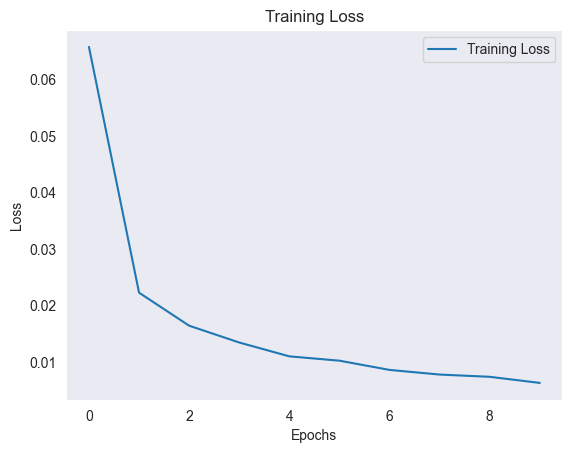

In [69]:
# Summary history for Loss
plt.plot(history.history['loss'], label ='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

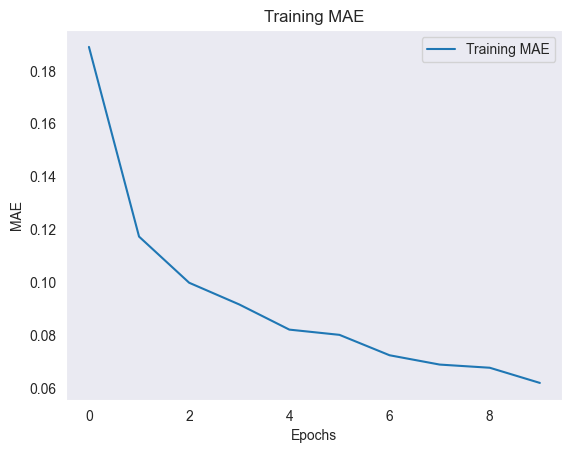

In [70]:
# Summary history for MAE
plt.plot(history.history['mae'], label ='Training MAE')
plt.title('Training MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


Visualizing embeddings for marque:


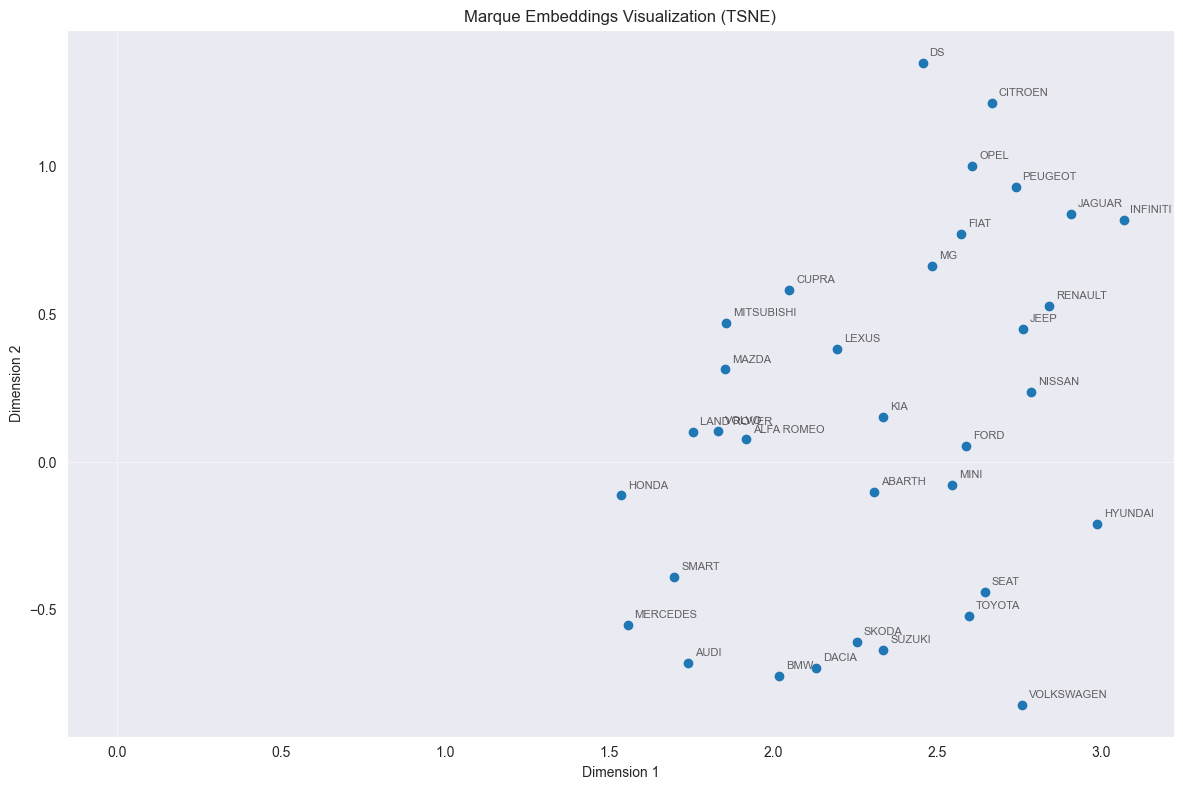

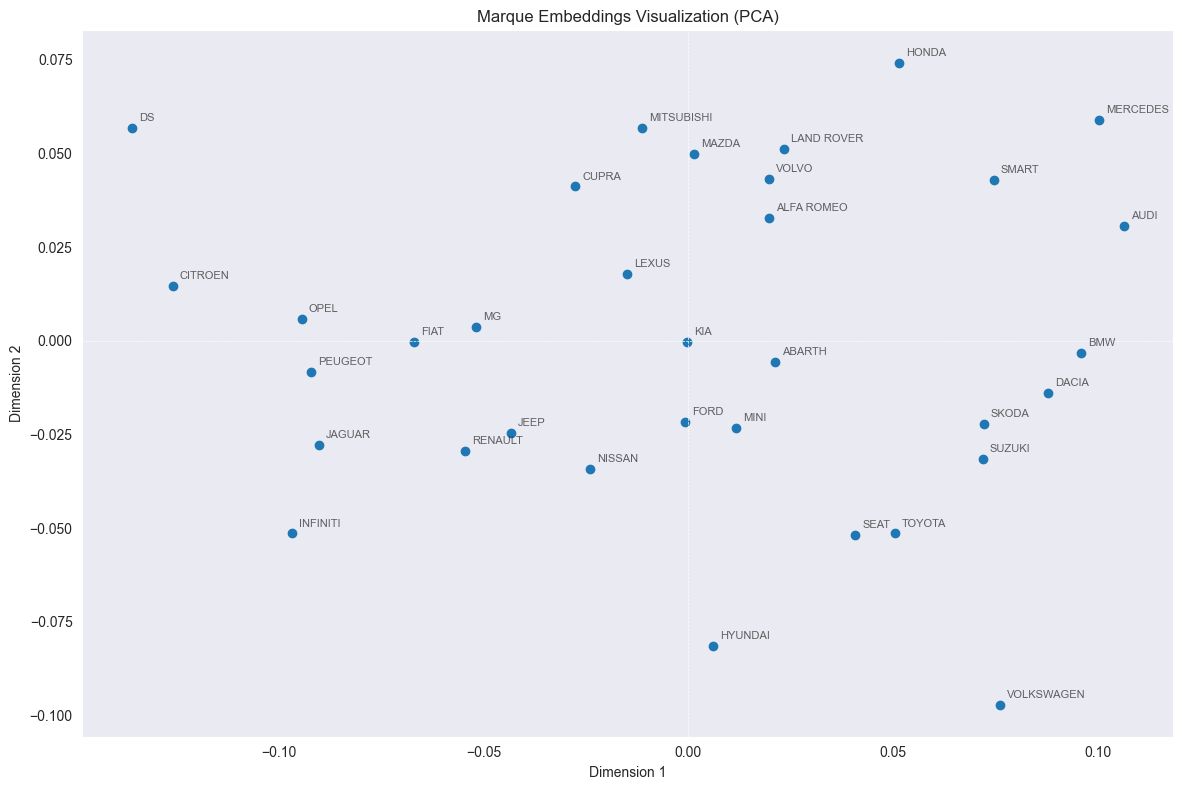


Visualizing embeddings for modele:


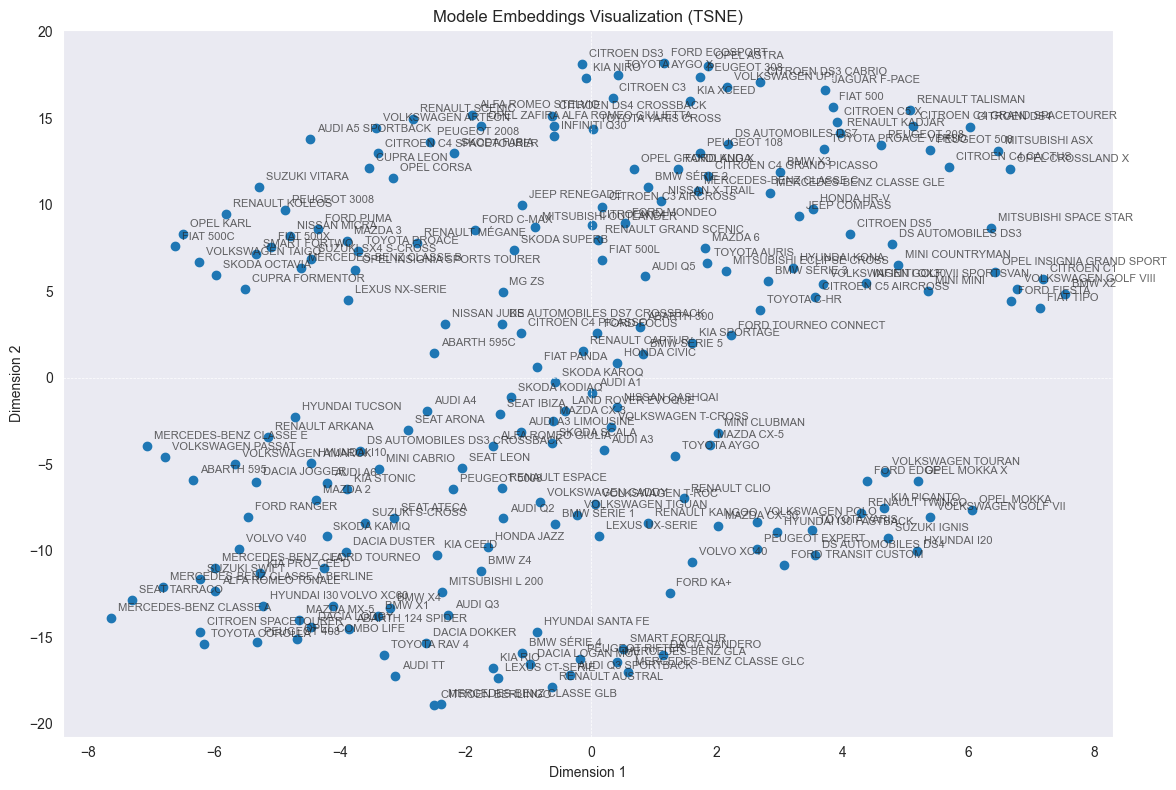

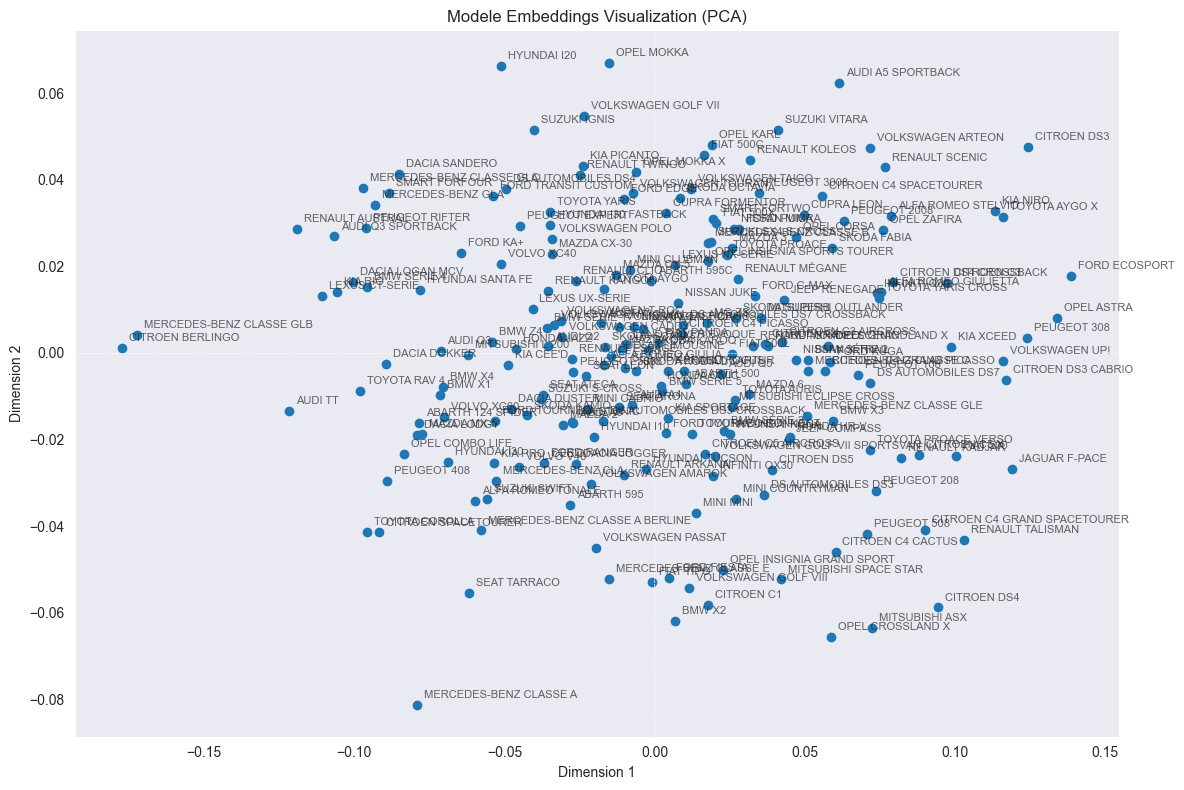

In [71]:
visualize_all_embeddings(model_handler, model)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R2: 0.8641, RMSE: 0.0425, MAE: 0.0336


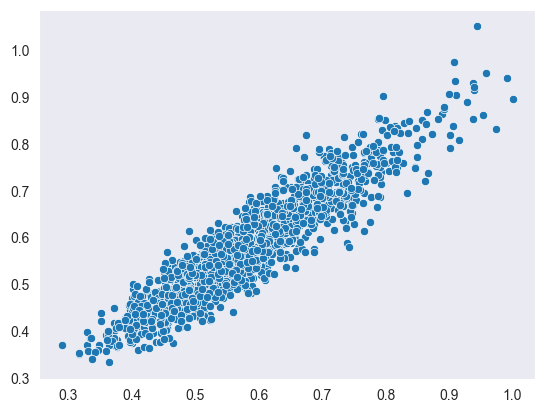

In [72]:
y_pred = model.predict(X_train_array)
y_pred = y_pred.flatten()
ax = sns.scatterplot(x=y_train_array, y=y_pred)

model_error = y_train_array - y_pred
R2 = 1 - sum(model_error**2) / sum((y_train_array - np.mean(y_train_array))**2)
RMSE = np.sqrt(np.mean(model_error**2))
MAE = np.mean(np.abs(model_error))
print(f"R2: {R2:.4f}, RMSE: {RMSE:.4f}, MAE: {MAE:.4f}")

In [267]:
df_embed_marque = get_embedding_weights(model, model_handler.encoders['marque'], 'marque')
df_embed_marque.head()

marque_0  marque_1
ABARTH     -0.019301  0.033357
ALFA ROMEO  0.017786  0.023338
AUDI        0.035268  0.108125
BMW        -0.000062  0.105609
CITROEN    -0.032816 -0.114334

In [268]:
df_embed_modele = get_embedding_weights(model, model_handler.encoders['modele'], 'modele')
df_embed_modele.head()

modele_0  modele_1
ABARTH 124 SPIDER -0.048351 -0.067143
ABARTH 500         0.010131  0.000570
ABARTH 595         0.001016 -0.046354
ABARTH 595C       -0.014719  0.009788
ALFA ROMEO GIULIA -0.012939 -0.015122

In [269]:
# df_embed_marque_clustered = cluster_embeddings(df_embed_marque, "marque", n_clusters=4, list_columns=['marque_0', 'marque_1'])

In [270]:
# df_embed_marque_clustered

In [271]:
# df_embed_modele_clustered = cluster_embeddings(df_embed_modele, "modele", n_clusters=5, list_columns=['modele_0', 'modele_1'])

In [272]:
# df_embed_modele_clustered

## VII. Variables encoding and scaling pipelines

In [273]:
# Nombre de modalités par variable catégorielle
{col : X_train[col].nunique() for col in X_train.select_dtypes(include="object").columns}

{'marque': 34,
 'modele': 217,
 'carburant': 4,
 'transmission': 2,
 'nb_ancien_proprietaire': 6,
 'classe_vehicule': 9,
 'nb_porte': 4,
 'nb_place': 6,
 'couleur': 13,
 'sellerie': 4,
 'classe_emission': 4,
 'crit_air': 2,
 'usage_commerciale_anterieure': 3,
 'annee': 8}

In [274]:
X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

['prix',
 'kilometrage',
 'puissance',
 'emission_CO2',
 'age_days',
 'age_years',
 'age_months',
 'km_per_year',
 'km_per_month',
 'id_annonce',
 'prix_neuf']

In [275]:
# Ajouter les coordonnées par marque dans les DataFrames d'entraînement et de test
df_embed_marque.reset_index(inplace=True)
df_embed_marque.rename(columns={'index': 'marque'}, inplace=True)
X_train_upd = pd.merge(X_train, df_embed_marque, on="marque", how="left")
X_y_train_upd = pd.merge(X_y_train, df_embed_marque, on="marque", how="left")
X_test_upd = pd.merge(X_test, df_embed_marque, on="marque", how="left")

# Ajouter les coordonnées par modèle dans les DataFrames d'entraînement et de test
df_embed_modele.reset_index(inplace=True)
df_embed_modele.rename(columns={'index': 'modele'}, inplace=True)
X_train_upd = pd.merge(X_train_upd, df_embed_modele, on="modele", how="left")
X_y_train_upd = pd.merge(X_y_train_upd, df_embed_modele, on="modele", how="left")
X_test_upd = pd.merge(X_test_upd, df_embed_modele, on="modele", how="left")

In [276]:
# Calculer la moyenne des points dans X_train pour utiliser dans les pipelines de transformation
imputer_marque_0 = df_embed_marque["marque_0"].mean()
imputer_marque_1 = df_embed_marque["marque_1"].mean()
print(f"Imputation pour marque: \n imputer_marque_0: {imputer_marque_0: .4f}, imputer_marque_1: {imputer_marque_1: .4f}")

imputer_modele_0 = df_embed_modele["modele_0"].mean()
imputer_modele_1 = df_embed_modele["modele_1"].mean()
print(f"Imputation pour modele: \n imputer_modele_0: {imputer_modele_0: .4f}, imputer_modele_1: {imputer_modele_1: .4f}")

Imputation pour marque: 
 imputer_marque_0: -0.0186, imputer_marque_1:  0.0116
Imputation pour modele: 
 imputer_modele_0: -0.0025, imputer_modele_1: -0.0015


In [277]:
# Supprimer les colonnes non pertinentes pour l'analyse
# id_annonce: c'est un identifiant unique pour chaque annonce, donc pas pertinent pour l'analyse
# annee: c'est l'année de l'annonce, mais on a déjà l'âge de la voiture en mois, donc pas nécessaire
# marque et modèle à remplacer par les embeddings
# La répartition des modalités au sein des variables comme: nb_place, nb_porte, classe_emission 
# n'est pas équilibre. Forte concentration sur une modalité => Supprimer ces variables pour éviter de biaiser le modèle.
# prix: c'est utilisé pour calculer la variable cible (ratio_vr), donc pas nécessaire dans les DataFrames d'entraînement et de test
# On va donc supprimer ces deux colonnes des DataFrames d'entraînement et de test
X_train_upd.drop(columns=['id_annonce', 'annee', 'modele', 'marque', 'prix', 'age_years', 'age_days', 'km_per_year', 'nb_place', 'nb_porte', 'classe_emission'], inplace=True)
X_y_train_upd.drop(columns=['id_annonce', 'annee', 'modele', 'marque', 'prix', 'age_years', 'age_days', 'km_per_year', 'nb_place', 'nb_porte', 'classe_emission'], inplace=True)
X_test_upd.drop(columns=['id_annonce', 'annee', 'modele', 'marque', 'prix', 'age_years', 'age_days', 'km_per_year', 'nb_place', 'nb_porte', 'classe_emission'], inplace=True)

In [278]:
cat_features_update = X_train_upd.select_dtypes(include=['object']).columns.tolist()
cat_to_transform = [cat for cat in cat_features_update if cat not in ['nb_ancien_proprietaire']]
print(cat_to_transform)

['carburant', 'transmission', 'classe_vehicule', 'couleur', 'sellerie', 'crit_air', 'usage_commerciale_anterieure']


In [279]:
# Valeur spéciale à imputer pour les variables catégorielles 
special_cat = {'nb_ancien_proprietaire': '1'}

In [280]:
num_features_update = X_train_upd.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Regular num
num_to_transform = [num for num in num_features_update if num not in ['marque_0', 'marque_1', 'modele_0', 'modele_1']]
print(num_to_transform)

['kilometrage', 'puissance', 'emission_CO2', 'age_months', 'km_per_month', 'prix_neuf']


In [281]:
# Variables numériques et leurs imputations spéciales
special_num = {'marque_0' : imputer_marque_0,
               'marque_1' : imputer_marque_1,
               'modele_0' : imputer_modele_0,
               'modele_1' : imputer_modele_1}
print(special_num)

{'marque_0': np.float32(-0.018600592), 'marque_1': np.float32(0.011577271), 'modele_0': np.float32(-0.0025286241), 'modele_1': np.float32(-0.0014783143)}


In [282]:
# Pipeline pour encoder les variables catégorielles & numériques
transform_pipeline = create_transformer_pipeline(categorical_features=cat_to_transform,
                                                 special_impute_cat_features=special_cat,
                                                 numerical_features=num_to_transform,
                                                 special_impute_num_features=special_num)
transform_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('nb_ancien_proprietaire',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='1',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['nb_ancien_proprietaire']),
                                ('regular_cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('oneho...
                                ('modele_1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=np.float32(-0.0014783143),
                                                                strategy='constant')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['modele_1']),
                                ('regular_num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['kilometrage', 'puissance', 'emission_CO2',
                                  'age_months', 'km_per_month', 'prix_neuf'])])

In [283]:
# Appliquer pipeline de transformation pour X_train et X_test
X_train_prepared = transform_pipeline.fit_transform(X_train_upd)
X_test_prepared = transform_pipeline.transform(X_test_upd)

In [284]:
X_train_prepared.shape, X_test_prepared.shape

((1869, 53), (468, 53))

In [285]:
# Display all transformers in the pipeline
for name, transformer, features in transform_pipeline.transformers_:
	print(f"Name: {name}, Transformer: {transformer}, Features: {features}")
	# Only access 'onehot' if it exists in the pipeline steps
	if hasattr(transformer, 'named_steps') and 'onehot' in transformer.named_steps:
		print(transformer.named_steps['onehot'])

Name: nb_ancien_proprietaire, Transformer: Pipeline(steps=[('imputer', SimpleImputer(fill_value='1', strategy='constant')),
                ('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), Features: ['nb_ancien_proprietaire']
OneHotEncoder(handle_unknown='ignore', sparse_output=False)
Name: regular_cat, Transformer: Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), Features: ['carburant', 'transmission', 'classe_vehicule', 'couleur', 'sellerie', 'crit_air', 'usage_commerciale_anterieure']
OneHotEncoder(handle_unknown='ignore', sparse_output=False)
Name: marque_0, Transformer: Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value=np.float32(-0.018600592),
                               strategy='constant')),
                ('std_scaler', StandardScaler())]), Features: ['marque_0']
Name: marque_1, Trans

In [286]:
# Ajouter le nom des colonnes dans la data transformée
feature_names = []
for name, transformer, features in transform_pipeline.transformers_:
    if name == 'remainder':
        feature_names.extend(X_train.columns[features])
    if name == 'regular_cat':
        encoder_cat = transformer.named_steps['onehot']
        feature_names.extend(encoder_cat.get_feature_names_out(features))
    elif name in special_cat.keys():
        encoder_spe_cat = transformer.named_steps['onehot']
        feature_names.extend(encoder_spe_cat.get_feature_names_out(features))
    elif name == 'regular_num':
        feature_names.extend(features)
    elif name in special_num.keys():
        feature_names.extend(features)

X_train_transformed_df = pd.DataFrame(X_train_prepared, columns=feature_names) 
X_test_transformed_df = pd.DataFrame(X_test_prepared, columns=feature_names) 

In [287]:
X_train_transformed_df

nb_ancien_proprietaire_1  nb_ancien_proprietaire_2  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
1864                       0.0                       1.0   
1865                       0.0                       0.0   
1866                       0.0                       1.0   
1867                       1.0                       0.0   
1868                       1.0                       0.0   

      nb_ancien_proprietaire_3  nb_ancien_proprietaire_4  \
0                          1.0                       0.0   
1                          1.0                       0.0   
2                          0.0                       0.0   
3                          1.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
1864                       0.0                       0.0   
1865                       1.0                       0.0   
1866                       0.0                       0.0   
1867                       0.0                       0.0   
1868                       0.0                       0.0   

      nb_ancien_proprietaire_5  nb_ancien_proprietaire_Inconnu  \
0                          0.0                             0.0   
1                          0.0                             0.0   
2                          0.0                             1.0   
3                          0.0                             0.0   
4                          0.0                             1.0   
...                        ...                             ...   
1864                       0.0                             0.0   
1865                       0.0                             0.0   
1866                       0.0                             0.0   
1867                       0.0                             0.0   
1868                       0.0                             0.0   

      carburant_Diesel  carburant_Essence  carburant_Ethanol  \
0                  0.0                1.0                0.0   
1                  1.0                0.0                0.0   
2                  0.0                1.0                0.0   
3                  0.0                1.0                0.0   
4                  1.0                0.0                0.0   
...                ...                ...                ...   
1864               0.0                1.0                0.0   
1865               0.0                1.0                0.0   
1866               1.0                0.0                0.0   
1867               0.0                1.0                0.0   
1868               1.0                0.0                0.0   

      carburant_Hybride  ...  marque_0  marque_1  modele_0  modele_1  \
0                   0.0  ... -0.115658  0.315162 -0.237209 -0.705913   
1                   0.0  ... -0.629453 -0.481322  0.092319  0.539354   
2                   0.0  ...  1.688207  1.328021 -2.095564 -1.345827   
3                   0.0  ... -1.516456  1.322380 -0.665962 -0.516630   
4                   0.0  ... -0.337005 -1.005429  1.754934  1.782044   
...                 ...  ...       ...       ...       ...       ...   
1864                0.0  ...  0.240783  1.059567 -0.522907 -1.034301   
1865                0.0  ... -0.629453 -0.481322  0.044834 -0.158613   
1866                0.0  ...  0.527049  1.229588 -0.625449 -1.095677   
1867                0.0  ... -0.629453 -0.481322 -0.721783 -0.286241   
1868                0.0  ... -0.632726  0.757188 -0.508090 -0.878095   

      kilometrage  puissance  emission_CO2  age_months  km_per_month  \
0        0.351486   1.642224      0.301331    0.871223     -0.342

## VIII. Training

### Linear Regression - Baseline model

In [288]:
# Lancer une régression linéaire pour prédire le ratio VR
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

LinearRegression()

In [289]:
pd.DataFrame(data=np.append(lin_reg.intercept_, lin_reg.coef_),
             index = ['Intercept'] + [col for col in X_train_transformed_df.columns],
             columns = ['Value']
             ).sort_values(by='Value', ascending =False)

Value
Intercept                                  0.606064
couleur_Violet                             0.065565
marque_1                                   0.044397
classe_vehicule_Roadster                   0.039720
puissance                                  0.029225
couleur_Vert                               0.026649
couleur_Or                                 0.025290
classe_vehicule_Pickup                     0.025250
emission_CO2                               0.015275
transmission_Boite de vitesse automatique  0.012740
classe_vehicule_Citadine                   0.012644
carburant_Diesel                           0.008991
crit_air_Crit'Air 2                        0.008991
km_per_month                               0.008691
marque_0                                   0.007763
carburant_Hybride                          0.007438
nb_ancien_proprietaire_1                   0.005845
couleur_Orange                             0.005802
usage_commerciale_anterieure_Unknown       0.005430
nb_ancien_proprietaire_4                   0.003469
nb_ancien_proprietaire_3                   0.003459
classe_vehicule_Monospace                  0.003274
sellerie_Cuir                              0.002726
sellerie_Alcantara                         0.002433
couleur_Rouge                              0.001945
couleur_Noir                              -0.000094
usage_commerciale_anterieure_Non          -0.000548
nb_ancien_proprietaire_2                  -0.001486
sellerie_Mi-cuir                          -0.001559
couleur_Bleu                              -0.002759
couleur_Marron                            -0.003335
sellerie_Tissu                            -0.003599
couleur_Gris                              -0.004059
couleur_Blanc                             -0.004143
carburant_Ethanol                         -0.004796
usage_commerciale_anterieure_Oui          -0.004883
nb_ancien_proprietaire_Inconnu            -0.005521
nb_ancien_proprietaire_5                  -0.005765
classe_vehicule_Cabriolet                 -0.006154
crit_air_Crit'Air 1                       -0.008991
classe_vehicule_Coupé                     -0.009648
couleur_Beige                             -0.010876
carburant_Essence                         -0.011633
transmission_Boite de vitesse manuelle    -0.012740
modele_1                                  -0.013591
classe_vehicule_Break                     -0.017200
classe_vehicule_SUV                       -0.017381
age_months                                -0.025712
modele_0                                  -0.027474
classe_vehicule_Berline                   -0.030506
kilometrage                               -0.044325
couleur_Jaune                             -0.046214
couleur_Argent                            -0.053771
prix_neuf                                 -0.075823

In [295]:
lin_reg_eval_train = model_evaluation(lin_reg, X_train_prepared, y_train, "Linear Regression Train")

Evaluation results for Linear Regression Train:
---------------------------------
Mean Absolute Error (MAE): 0.03558725258165298
Mean Squared Error (MSE): 0.002050089412854161
Root Mean Squared Error (RMSE): 0.04527791307971428
R-squared (R2): 0.845507388650547
Adjusted R-squared (Adj R2): 0.8409960341593509


In [296]:
lin_reg_eval = model_evaluation(lin_reg, X_test_prepared, y_test, "Linear Regression Test")

Evaluation results for Linear Regression Test:
---------------------------------
Mean Absolute Error (MAE): 0.03715015682057082
Mean Squared Error (MSE): 0.0023433487616117956
Root Mean Squared Error (RMSE): 0.048408147677966314
R-squared (R2): 0.8079447842179268
Adjusted R-squared (Adj R2): 0.7833580053859223


### XG Boost

In [316]:
# Tester XG Boost
xg_boost = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state= 42, max_depth=5)
xg_boost.fit(X_train_transformed_df, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [317]:
xg_boost_eval_train = model_evaluation(xg_boost, X_train_transformed_df, y_train, "XG Boost Regression Train")

Evaluation results for XG Boost Regression Train:
---------------------------------
Mean Absolute Error (MAE): 0.007672244025804278
Mean Squared Error (MSE): 0.00011235232926708785
Root Mean Squared Error (RMSE): 0.010599638166800216
R-squared (R2): 0.991533245022957
Adjusted R-squared (Adj R2): 0.9912860064478698


In [318]:
xg_boost_eval = model_evaluation(xg_boost, X_test_transformed_df, y_test, "XG Boost Regression Test")

Evaluation results for XG Boost Regression Test:
---------------------------------
Mean Absolute Error (MAE): 0.026296435795418068
Mean Squared Error (MSE): 0.0013092218818164054
Root Mean Squared Error (RMSE): 0.036183171251514226
R-squared (R2): 0.8926993304889388
Adjusted R-squared (Adj R2): 0.8789627713486339


<Axes: title={'center': 'Top 10 Features Importance for XG Boost Regression'}, ylabel='Feature'>

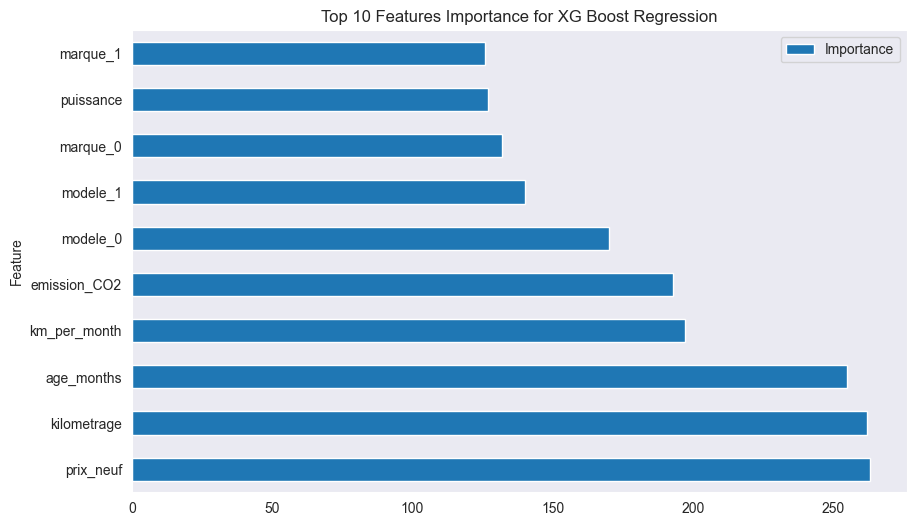

In [319]:
# Feature importance for XG Boost
xg_boost_importance = xg_boost.get_booster().get_score(importance_type='weight')
xg_boost_importance_df = pd.DataFrame(xg_boost_importance.items(), columns=['Feature', 'Importance'])
xg_boost_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
xg_boost_importance_df.reset_index(drop=True, inplace=True)
xg_boost_importance_df.nlargest(10, columns="Importance").plot(kind='barh', x='Feature', y='Importance', figsize=(10,6), title = "Top 10 Features Importance for XG Boost Regression")

In [320]:
# Visualiser y_train_pred et age_months et kilometrage
y_train_pred = xg_boost.predict(X_train_prepared)
# Ajouter les prédictions au DataFrame d'entraînement
X_y_train_upd[target_variable + '_pred_XG_boost'] = y_train_pred

scatter_3d(X_y_train_upd, x="age_months", y="kilometrage", z=target_variable + '_pred_XG_boost',
           x_title ="Age (mois)", y_title="Kilometrage (km)", z_title="Ratio VR Prédit")

### XG Boost + monotonicity constrained

In [326]:
# Ajouter les contraintes de monotonie
# -1 pour une contrainte décroissante par rapport à la VR ratio
monotonic_constraints = {"kilometrage": -1, "age_months": -1, 'prix_neuf': -1}
xg_boost_cst = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state= 42, max_depth = 5, monotone_constraints=monotonic_constraints)
xg_boost_cst.fit(X_train_transformed_df, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan,
             monotone_constraints={'age_months': -1, 'kilometrage': -1,
                                   'prix_neuf': -1},
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [327]:
xg_boost_cst_eval_train = model_evaluation(xg_boost_cst, X_train_transformed_df, y_train, "XG Boost Regression + Monotonic Constraints on Train set")

Evaluation results for XG Boost Regression + Monotonic Constraints on Train set:
---------------------------------
Mean Absolute Error (MAE): 0.009883064114410877
Mean Squared Error (MSE): 0.00017868553375765522
Root Mean Squared Error (RMSE): 0.01336733083893921
R-squared (R2): 0.9865344435479241
Adjusted R-squared (Adj R2): 0.9861412344614447


<Axes: title={'center': 'Top 10 Features Importance for XG Boost Regression'}, ylabel='Feature'>

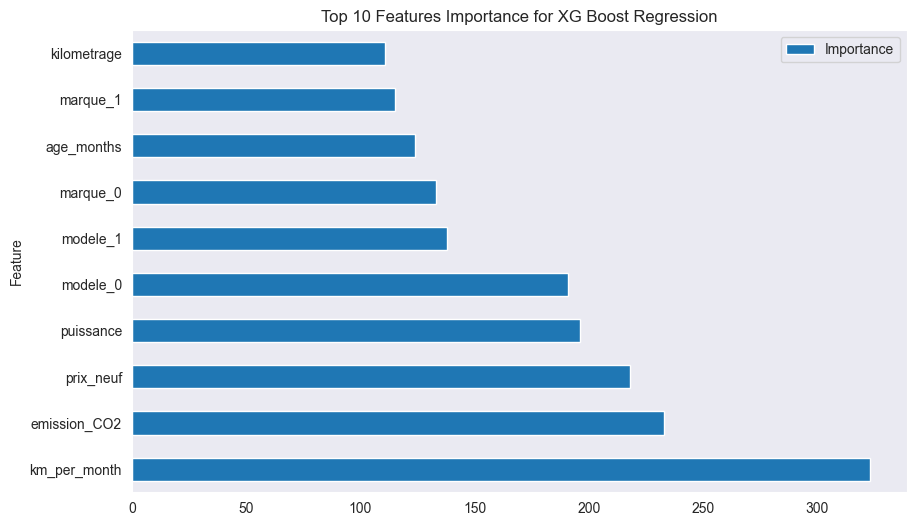

In [328]:
# Feature importance for XG Boost
xg_boost_importance = xg_boost_cst.get_booster().get_score(importance_type='weight')
xg_boost_importance_df = pd.DataFrame(xg_boost_importance.items(), columns=['Feature', 'Importance'])
xg_boost_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
xg_boost_importance_df.reset_index(drop=True, inplace=True)
xg_boost_importance_df.nlargest(10, columns="Importance").plot(kind='barh', x='Feature', y='Importance', figsize=(10,6), title = "Top 10 Features Importance for XG Boost Regression")

In [329]:
xg_boost_cst_eval = model_evaluation(xg_boost_cst, X_test_transformed_df, y_test, "XG Boost Regression + Monotonic Constraints on Test set")

Evaluation results for XG Boost Regression + Monotonic Constraints on Test set:
---------------------------------
Mean Absolute Error (MAE): 0.028934310235667577
Mean Squared Error (MSE): 0.0016469017122540393
Root Mean Squared Error (RMSE): 0.04058203681746444
R-squared (R2): 0.8650239055746608
Adjusted R-squared (Adj R2): 0.8477443572545087


In [330]:
# Visualiser y_train_pred et age_months et kilometrage
y_train_pred = xg_boost_cst.predict(X_train_prepared)
# Ajouter les prédictions au DataFrame d'entraînement
X_y_train_upd[target_variable + '_pred_XG_boost_cst'] = y_train_pred

scatter_3d(X_y_train_upd, x="age_months", y="kilometrage", z=target_variable + '_pred_XG_boost_cst',
           x_title ="Age (mois)", y_title="Kilometrage", z_title="Ratio VR Prédit")

### XG Boost + monotonicity constrained + Regularization Lasso

In [338]:
# Ajouter les contraintes de monotonie
# -1 pour une contrainte décroissante par rapport à la VR ratio
monotonic_constraints = {"kilometrage": -1, "age_months": -1, 'prix_neuf': -1}

In [355]:
# Créer une boucle pour évaluer le modèle avec différentes valeurs de alpha
alpha = [0.01, 0.1, 0.5, 1, 2, 5, 10]

df_eval_xgboost_train = pd.DataFrame()
df_eval_xgboost_test = pd.DataFrame()

for a in alpha:
    xg_boost_cst_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state= 42, max_depth = 5, 
                                        alpha = a, 
                                        monotone_constraints=monotonic_constraints)
    xg_boost_cst_reg.fit(X_train_transformed_df, y_train)

    print(f"Evaluation for alpha = {a}")
    
    xg_boost_cst_reg_eval_train = model_evaluation(xg_boost_cst_reg, X_train_transformed_df, y_train, f"Alpha {a} on Train set")
    xg_boost_cst_reg_eval = model_evaluation(xg_boost_cst_reg, X_test_transformed_df, y_test, f"Alpha {a} on Test set")

    df_eval_xgboost_train = pd.concat([df_eval_xgboost_train, xg_boost_cst_reg_eval_train], axis=1)
    df_eval_xgboost_test = pd.concat([df_eval_xgboost_test, xg_boost_cst_reg_eval], axis=1)


Evaluation for alpha = 0.01
Evaluation results for Alpha 0.01 on Train set:
---------------------------------
Mean Absolute Error (MAE): 0.009960560251234728
Mean Squared Error (MSE): 0.00017857970940802925
Root Mean Squared Error (RMSE): 0.013363371932563624
R-squared (R2): 0.9865424183611275
Adjusted R-squared (Adj R2): 0.9861494421479814
Evaluation results for Alpha 0.01 on Test set:
---------------------------------
Mean Absolute Error (MAE): 0.027881361456523514
Mean Squared Error (MSE): 0.0015454655721308219
Root Mean Squared Error (RMSE): 0.039312409899811815
R-squared (R2): 0.8733373671039918
Adjusted R-squared (Adj R2): 0.8571221025061937
Evaluation for alpha = 0.1
Evaluation results for Alpha 0.1 on Train set:
---------------------------------
Mean Absolute Error (MAE): 0.012342598040527527
Mean Squared Error (MSE): 0.0002648897720771281
Root Mean Squared Error (RMSE): 0.016275434620222223
R-squared (R2): 0.9800381815781475
Adjusted R-squared (Adj R2): 0.9794552744837353
Eval

In [356]:
df_eval_xgboost_train

Alpha 0.01 on Train set  Alpha 0.1 on Train set  \
MAE                         0.009961                0.012343   
MSE                         0.000179                0.000265   
RMSE                        0.013363                0.016275   
R2                          0.986542                0.980038   
ADJUSTED R2                 0.986149                0.979455   

             Alpha 0.5 on Train set  Alpha 1 on Train set  \
MAE                        0.021341              0.025793   
MSE                        0.000747              0.001083   
RMSE                       0.027326              0.032904   
R2                         0.943727              0.918412   
ADJUSTED R2                0.942084              0.916029   

             Alpha 2 on Train set  Alpha 5 on Train set  Alpha 10 on Train set  
MAE                      0.031096              0.037548               0.044154  
MSE                      0.001583              0.002306               0.003313  
RMSE                     0.039786              0.048017               0.057558  
R2                       0.880711              0.826250               0.750341  
ADJUSTED R2              0.877228              0.821177               0.743051

In [357]:
df_eval_xgboost_test

Alpha 0.01 on Test set  Alpha 0.1 on Test set  \
MAE                        0.027881               0.028629   
MSE                        0.001545               0.001494   
RMSE                       0.039312               0.038657   
R2                         0.873337               0.877524   
ADJUSTED R2                0.857122               0.861844   

             Alpha 0.5 on Test set  Alpha 1 on Test set  Alpha 2 on Test set  \
MAE                       0.031455             0.033994             0.036190   
MSE                       0.001706             0.001931             0.002153   
RMSE                      0.041304             0.043939             0.046399   
R2                        0.860177             0.841768             0.823556   
ADJUSTED R2               0.842277             0.821511             0.800968   

             Alpha 5 on Test set  Alpha 10 on Test set  
MAE                     0.041141              0.045636  
MSE                     0.002769              0.003518  
RMSE                    0.052617              0.059314  
R2                      0.773096              0.711663  
ADJUSTED R2             0.744048              0.674751

Evaluation results for XG Boost Regression + Monotonic Constraints on Test set with alpha = 1:
---------------------------------
Mean Absolute Error (MAE): 0.03145459240848955
Mean Squared Error (MSE): 0.0017060354382660266
Root Mean Squared Error (RMSE): 0.041304181849614534
R-squared (R2): 0.860177447934519
Adjusted R-squared (Adj R2): 0.8422774593850734


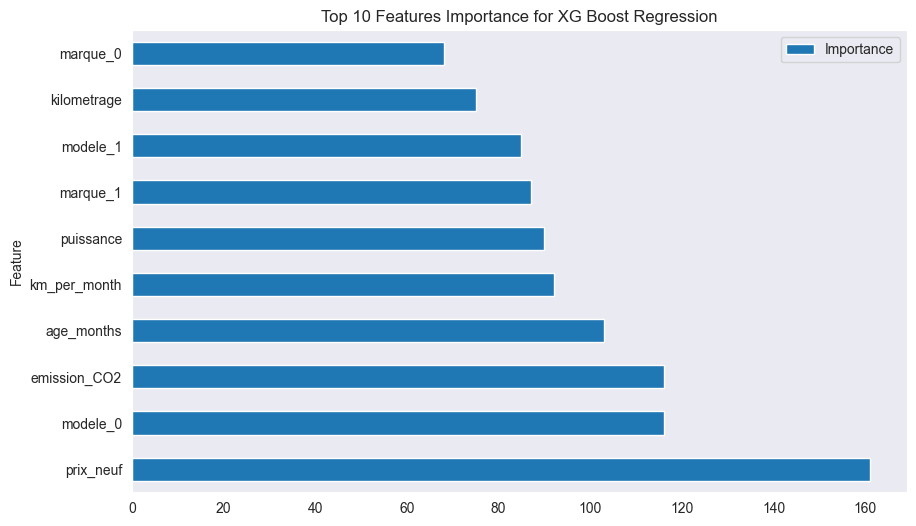

In [358]:
# Keep alpha = 0.5
xg_boost_cst_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state= 42, max_depth = 5, 
                                        alpha = 0.5, 
                                        monotone_constraints=monotonic_constraints)
xg_boost_cst_reg.fit(X_train_transformed_df, y_train)

# Feature importance for XG Boost
xg_boost_importance = xg_boost_cst_reg.get_booster().get_score(importance_type='weight')
xg_boost_importance_df = pd.DataFrame(xg_boost_importance.items(), columns=['Feature', 'Importance'])
xg_boost_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
xg_boost_importance_df.reset_index(drop=True, inplace=True)
xg_boost_importance_df.nlargest(10, columns="Importance").plot(kind='barh', x='Feature', y='Importance', figsize=(10,6), title = "Top 10 Features Importance for XG Boost Regression")

test_evaluation = model_evaluation(xg_boost_cst_reg, X_test_transformed_df, y_test, "XG Boost Regression + Monotonic Constraints on Test set with alpha = 1")

## IX. Model saving

In [363]:
df_embed_marque

marque  marque_0  marque_1
0       ABARTH -0.019301  0.033357
1   ALFA ROMEO  0.017786  0.023338
2         AUDI  0.035268  0.108125
3          BMW -0.000062  0.105609
4      CITROEN -0.032816 -0.114334
5        CUPRA  0.015245 -0.024586
6        DACIA -0.012273  0.100349
7           DS  0.005933 -0.133593
8         FIAT -0.034250 -0.053591
9         FORD -0.040007  0.015689
10       HONDA  0.065388  0.044911
11     HYUNDAI -0.096662  0.035965
12    INFINITI -0.090637 -0.070966
13      JAGUAR -0.066196 -0.069927
14        JEEP -0.052512 -0.024988
15         KIA -0.019045  0.011372
16  LAND ROVER  0.036493  0.022618
17       LEXUS -0.004699 -0.007004
18       MAZDA  0.030269  0.001707
19    MERCEDES  0.061543  0.095861
20          MG -0.026653 -0.039681
21        MINI -0.038588  0.028117
22  MITSUBISHI  0.034190 -0.012299
23      NISSAN -0.057360 -0.004079
24        OPEL -0.034269 -0.081583
25     PEUGEOT -0.047650 -0.076200
26     RENAULT -0.059624 -0.034799
27        SEAT -0.059758  0.063033
28       SKODA -0.023994  0.086919
29       SMART  0.040059  0.074488
30      SUZUKI -0.033032  0.088753
31      TOYOTA -0.057270  0.072339
32  VOLKSWAGEN -0.095941  0.107679
33       VOLVO  0.028005  0.021029

In [ ]:
# Création d'un répertoire pour sauvegarder les modèles
model_dir = os.path.join('..', 'models')
os.makedirs(model_dir, exist_ok=True)

# Sauvegarder le modèle XG Boost avec les contraintes de monotonie + régularisation
model_path = os.path.join(model_dir, 'xg_boost_cst_reg.joblib')
joblib.dump(xg_boost_cst_reg, model_path)

# Sauvegarder le pipeline de transformation
transformer_path = os.path.join(model_dir, 'transform_pipeline.joblib')
joblib.dump(transform_pipeline, transformer_path)

# Sauvegarder le df pour embedding marque et modele
embed_marque = os.path.join(model_dir, 'embedding_marque.joblib')
joblib.dump(df_embed_marque, embed_marque)
embed_modele = os.path.join(model_dir, 'embedding_modele.joblib')
joblib.dump(df_embed_modele, embed_modele)

['..\\models\\embedding_modele.joblib']

In [369]:
X.head()

marque             modele     prix  kilometrage carburant  \
0      FORD        FORD FIESTA  13190.0      69301.0   Essence   
2    TOYOTA      TOYOTA PROACE  23990.0      71887.0    Diesel   
4  MERCEDES  MERCEDES-BENZ GLA  32490.0      59649.0   Hybride   
5       BMW             BMW X1  27890.0      37869.0   Essence   
6   PEUGEOT       PEUGEOT 3008  19090.0      58958.0    Diesel   

                   transmission  puissance nb_ancien_proprietaire  \
0     Boite de vitesse manuelle         95                      3   
2     Boite de vitesse manuelle        120                      2   
4  Boite de vitesse automatique        218                      2   
5  Boite de vitesse automatique        136                      2   
6  Boite de vitesse automatique        130                      3   

  classe_vehicule nb_porte  ...    crit_air usage_commerciale_anterieure  \
0        Citadine        5  ...  Crit'Air 1                      Unknown   
2       Monospace        4  ...  Crit'Air 2                          Oui   
4             SUV        5  ...  Crit'Air 1                          Oui   
5             SUV        5  ...  Crit'Air 1                          Non   
6             SUV        5  ...  Crit'Air 2                          Oui   

  annee age_days  age_years age_months km_per_year km_per_month  id_annonce  \
0  2020   1790.0        4.9       59.7     14143.1       1160.8           1   
2  2021   1441.0        3.9       48.0     18432.6       1497.6           2   
4  2020   1629.0        4.5       54.3     13255.3       1098.5           3   
5  2021   1435.0        3.9       47.8      9710.0        792.2           4   
6  2019   1926.0        5.3       64.2     11124.2        918.3           5   

   prix_neuf  
0    21650.0  
2    34265.0  
4    55600.0  
5    41850.0  
6    38650.0  

[5 rows x 25 columns]

In [375]:
# Save some data
car_data = X.drop(columns=['id_annonce', 'prix', 'age_years', 'age_days', 'km_per_month', 'km_per_year', 'nb_place', 'nb_porte', 'classe_emission'])

In [386]:
# Date de mise en circulation = 09/04/2025 - age_months
car_data['Mise_en_circulation'] = car_data['age_months'].apply(
	lambda m: pd.to_datetime('2025-04-09') - pd.DateOffset(months=int(m)) if pd.notnull(m) else pd.NaT
)
car_data['Mise_en_circulation'] = car_data['Mise_en_circulation'].dt.strftime('%d/%m/%Y')
car_data['sellerie'] = car_data['sellerie'].str.split('(').str[0]

car_data.drop("age_months", axis=1, inplace=True)

In [387]:
# Créer un répertoire pour sauvegarder les données à utiliser dans l'outil app
outil_data_dir= os.path.join("..", "data", "outil_data")
os.makedirs(outil_data_dir, exist_ok=True)

# Sauvegarder les données 
car_data_path = os.path.join(outil_data_dir, 'sample_app_car_data.csv')
car_data.to_csv(car_data_path, index=False)